# GPL Paper Section 4.1.2 Experiment: Quadratic Hamiltonian with L1 Prior

This code attempts to learn 8D prior $J(x) = \|x\|_1$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian
$H(p) = \frac{1}{2}\|p\|_2^2$.
The LPN learns the function $\psi(y) = J^*(y) - \frac{1}{2}\|y\|_2^2$.
Training data uses samples $\{y_j,\psi(y_j)\}$ where $\psi(y_j) = \frac{1}{2}\|y_j\|_2^2 - S(y_j,1)$, and,
$S(y_j,1) = \min_{x \in \mathbb{R}^d} \{\frac{1}{2}\|x-y_j\|_2^2 + \|x\|_1\}$ (Moreau envelope of $J(x)=\|x\|_1$ at $t=1$).

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_2_quadratic_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters for Sec 4.1.2 L1 Prior Experiment ---
dim_exp = 8  
data_points_exp = 30000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)

def prox_l1_vec(y, t_lambda):
    """ Element-wise proximal operator of t_lambda*||x||_1 (soft-thresholding). """
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_quadratic_l1(y_points,n=1.0, t=1.0): # y_points is N x dim
    """
    Computes S(y, t=1) for J(x)=||x||_1.
    S(y, 1) = ||x||_1 + nt/2 }
    """
    t_moreau = 1.0
    prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    s_values = np.sum(np.abs(prox_y), axis=1) +n * t/2 # L1 norm for each vector y_j 
    return s_values # N-dimensional array

def prior_true_quadratic_l1(y_points): # y_points is N x dim
    """ Computes the true prior J(y) = ||y||_1. """
    return np.sum(np.abs(y_points), axis=1) # N-dimensional array

def cvx_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = 0.5*||y||_2^2 - S(y, t=1) for J(x)=||x||_1.
    """
    s_y_1 = hjsol_true_quadratic_l1(y_points)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y # N-dimensional array

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_quadratic_l1(x1_0_points)
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_quadratic_l1(x2_0_points)
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim={dim}) ---")
    cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim)



In [4]:

def exp_func(x, gamma):
    # Ensure x is a 1D tensor for vector_norm if it comes in as N x 1
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze(1)
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim=-1)/ gamma) ** 2)) + 1.0

# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")
# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
cvx_samples_exp_tensor = cvx_samples_exp_tensor.to(device)

Generated training data: y_j_exp_tensor shape torch.Size([30000, 8]), cvx_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L1 loss -- Train

In [7]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_quad_l1.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l1.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---


iteration 0 loss 12.099188804626465
iteration 0 loss 27.89728355407715


iteration 500 loss 1.7757794857025146


iteration 1000 loss 1.7292650938034058


iteration 1500 loss 1.6676921844482422


iteration 2000 loss 1.5657007694244385


iteration 2500 loss 1.3695275783538818


iteration 3000 loss 0.8748244643211365


iteration 3500 loss 0.3572690188884735


iteration 4000 loss 0.3077237010002136


iteration 4500 loss 0.29033875465393066


iteration 5000 loss 0.2795950472354889


iteration 5500 loss 0.2721915543079376


iteration 6000 loss 0.2660248875617981


iteration 6500 loss 0.2627643942832947


iteration 7000 loss 0.25818145275115967


iteration 7500 loss 0.2543296813964844


iteration 8000 loss 0.2505400776863098


iteration 8500 loss 0.24599456787109375


iteration 9000 loss 0.2418288141489029


iteration 9500 loss 0.23876015841960907


iteration 10000 loss 0.23534677922725677


iteration 10500 loss 0.23387974500656128


iteration 11000 loss 0.23129218816757202


iteration 11500 loss 0.22810029983520508


iteration 12000 loss 0.22664518654346466


iteration 12500 loss 0.2234662026166916


iteration 13000 loss 0.22161580622196198


iteration 13500 loss 0.22026845812797546


iteration 14000 loss 0.21816015243530273


iteration 14500 loss 0.2157900035381317


iteration 15000 loss 0.2142571359872818


iteration 15500 loss 0.2120434045791626


iteration 16000 loss 0.21114422380924225


iteration 16500 loss 0.20899821817874908


iteration 17000 loss 0.2072756141424179


iteration 17500 loss 0.20717546343803406


iteration 18000 loss 0.2044801563024521


iteration 18500 loss 0.20306496322155


iteration 19000 loss 0.20327317714691162


iteration 19500 loss 0.20037135481834412


iteration 20000 loss 0.20086155831813812


iteration 20500 loss 0.1989980936050415


iteration 21000 loss 0.19774556159973145


iteration 21500 loss 0.1963290423154831


iteration 22000 loss 0.19504733383655548


iteration 22500 loss 0.1926071047782898


iteration 23000 loss 0.19236741960048676


iteration 23500 loss 0.19187681376934052


iteration 24000 loss 0.18898740410804749


iteration 24500 loss 0.18781837821006775


iteration 25000 loss 0.18668372929096222


iteration 25500 loss 0.18798860907554626


iteration 26000 loss 0.18475621938705444


iteration 26500 loss 0.18344083428382874


iteration 27000 loss 0.18316146731376648


iteration 27500 loss 0.18259762227535248


iteration 28000 loss 0.1817588210105896


iteration 28500 loss 0.1795053333044052


iteration 29000 loss 0.1811196655035019


iteration 29500 loss 0.1778370440006256


iteration 30000 loss 0.17893868684768677


iteration 30500 loss 0.17663542926311493


iteration 31000 loss 0.1757017970085144


iteration 31500 loss 0.17430490255355835


iteration 32000 loss 0.1734982132911682


iteration 32500 loss 0.17332307994365692


iteration 33000 loss 0.17436648905277252


iteration 33500 loss 0.170946404337883


iteration 34000 loss 0.17147724330425262


iteration 34500 loss 0.1692836731672287


iteration 35000 loss 0.17103587090969086


iteration 35500 loss 0.1676775962114334


iteration 36000 loss 0.1669127345085144


iteration 36500 loss 0.16778531670570374


iteration 37000 loss 0.16577546298503876


iteration 37500 loss 0.16463841497898102


iteration 38000 loss 0.16397301852703094


iteration 38500 loss 0.16279472410678864


iteration 39000 loss 0.1647121012210846


iteration 39500 loss 0.162916362285614


iteration 40000 loss 0.16044268012046814


iteration 40500 loss 0.1596606820821762


iteration 41000 loss 0.15893664956092834


iteration 41500 loss 0.16083216667175293


iteration 42000 loss 0.1580246537923813


iteration 42500 loss 0.15667687356472015


iteration 43000 loss 0.158472940325737


iteration 43500 loss 0.15513575077056885


iteration 44000 loss 0.1568491905927658


iteration 44500 loss 0.15368638932704926


iteration 45000 loss 0.15542303025722504


iteration 45500 loss 0.15227867662906647


iteration 46000 loss 0.15174084901809692


iteration 46500 loss 0.1527256816625595


iteration 47000 loss 0.15222327411174774


iteration 47500 loss 0.14948143064975739


iteration 48000 loss 0.150024875998497


iteration 48500 loss 0.14812377095222473


iteration 49000 loss 0.1486235409975052


iteration 49500 loss 0.1468043327331543


iteration 50000 loss 0.14609894156455994


iteration 50500 loss 0.14586494863033295


iteration 51000 loss 0.14547578990459442


iteration 51500 loss 0.1459265947341919


iteration 52000 loss 0.14395825564861298


iteration 52500 loss 0.14345243573188782


iteration 53000 loss 0.14327014982700348


iteration 53500 loss 0.14448551833629608


iteration 54000 loss 0.1409420371055603


iteration 54500 loss 0.1430548131465912


iteration 55000 loss 0.13971318304538727


iteration 55500 loss 0.14040248095989227


iteration 56000 loss 0.13901348412036896


iteration 56500 loss 0.13792367279529572


iteration 57000 loss 0.13874724507331848


iteration 57500 loss 0.1379101276397705


iteration 58000 loss 0.13674691319465637


iteration 58500 loss 0.13672128319740295


iteration 59000 loss 0.13654059171676636


iteration 59500 loss 0.13498957455158234


iteration 60000 loss 0.1342894434928894


iteration 60500 loss 0.1351478546857834


iteration 61000 loss 0.1356084942817688


iteration 61500 loss 0.13401927053928375


iteration 62000 loss 0.13207481801509857


iteration 62500 loss 0.13193529844284058


iteration 63000 loss 0.1311379075050354


iteration 63500 loss 0.1324460357427597


iteration 64000 loss 0.13118185102939606


iteration 64500 loss 0.13097146153450012


iteration 65000 loss 0.13154345750808716


iteration 65500 loss 0.12971074879169464


iteration 66000 loss 0.1287795752286911


iteration 66500 loss 0.13055847585201263


iteration 67000 loss 0.13062931597232819


iteration 67500 loss 0.12768833339214325


iteration 68000 loss 0.12955832481384277


iteration 68500 loss 0.12924280762672424


iteration 69000 loss 0.12901335954666138


iteration 69500 loss 0.126626655459404


iteration 70000 loss 0.12610459327697754


iteration 70500 loss 0.1276332139968872


iteration 71000 loss 0.125531867146492


iteration 71500 loss 0.12721271812915802


iteration 72000 loss 0.12493810057640076


iteration 72500 loss 0.1255752146244049


iteration 73000 loss 0.12655536830425262


iteration 73500 loss 0.12754051387310028


iteration 74000 loss 0.1239008828997612


iteration 74500 loss 0.12651865184307098


iteration 75000 loss 0.12557940185070038


iteration 75500 loss 0.12632928788661957


iteration 76000 loss 0.1248156949877739


iteration 76500 loss 0.12627172470092773


iteration 77000 loss 0.12336774170398712


iteration 77500 loss 0.1227371096611023


iteration 78000 loss 0.12570329010486603


iteration 78500 loss 0.1218678206205368


iteration 79000 loss 0.12482203543186188


iteration 79500 loss 0.12234148383140564


iteration 80000 loss 0.12153436243534088


iteration 80500 loss 0.12135029584169388


iteration 81000 loss 0.12330332398414612


iteration 81500 loss 0.12304084748029709


iteration 82000 loss 0.12124810367822647


iteration 82500 loss 0.12220325320959091


iteration 83000 loss 0.12331528216600418


iteration 83500 loss 0.12023904174566269


iteration 84000 loss 0.11987568438053131


iteration 84500 loss 0.12055618315935135


iteration 85000 loss 0.12238482385873795


iteration 85500 loss 0.11945732682943344


iteration 86000 loss 0.12106303870677948


iteration 86500 loss 0.12186979502439499


iteration 87000 loss 0.12170762568712234


iteration 87500 loss 0.11967728286981583


iteration 88000 loss 0.119245246052742


iteration 88500 loss 0.11928275972604752


iteration 89000 loss 0.11957265436649323


iteration 89500 loss 0.11830788105726242


iteration 90000 loss 0.12073986977338791


iteration 90500 loss 0.12090294808149338


iteration 91000 loss 0.12121544033288956


iteration 91500 loss 0.11991430073976517


iteration 92000 loss 0.12003973126411438


iteration 92500 loss 0.11995171010494232


iteration 93000 loss 0.1184392124414444


iteration 93500 loss 0.11750331521034241


iteration 94000 loss 0.11774604767560959


iteration 94500 loss 0.11710084229707718


iteration 95000 loss 0.1198418065905571


iteration 95500 loss 0.11743985861539841


iteration 96000 loss 0.1172199472784996


iteration 96500 loss 0.11665963381528854


iteration 97000 loss 0.11711946874856949


iteration 97500 loss 0.11735226213932037


iteration 98000 loss 0.11854652315378189


iteration 98500 loss 0.11899585276842117


iteration 99000 loss 0.11769810318946838


iteration 99500 loss 0.116036556661129


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.11912959069013596


iteration 100500 loss 0.11586201190948486


iteration 101000 loss 0.11581714451313019


iteration 101500 loss 0.11577218770980835


iteration 102000 loss 0.11573586612939835


iteration 102500 loss 0.11568660289049149


iteration 103000 loss 0.11564834415912628


iteration 103500 loss 0.11562264710664749


iteration 104000 loss 0.11553267389535904


iteration 104500 loss 0.1154804676771164


iteration 105000 loss 0.1154264584183693


iteration 105500 loss 0.11539702862501144


iteration 106000 loss 0.11540234833955765


iteration 106500 loss 0.11535811424255371


iteration 107000 loss 0.11531100422143936


iteration 107500 loss 0.1153058260679245


iteration 108000 loss 0.11528024822473526


iteration 108500 loss 0.11520815640687943


iteration 109000 loss 0.11514967679977417


iteration 109500 loss 0.1151040568947792


iteration 110000 loss 0.11506280303001404


iteration 110500 loss 0.11513233929872513


iteration 111000 loss 0.11508350819349289


iteration 111500 loss 0.11502231657505035


iteration 112000 loss 0.11498123407363892


iteration 112500 loss 0.11491836607456207


iteration 113000 loss 0.11489344388246536


iteration 113500 loss 0.11489056050777435


iteration 114000 loss 0.11485984921455383


iteration 114500 loss 0.11489410698413849


iteration 115000 loss 0.1148097813129425


iteration 115500 loss 0.11478406935930252


iteration 116000 loss 0.11484047770500183


iteration 116500 loss 0.11479039490222931


iteration 117000 loss 0.11475788056850433


iteration 117500 loss 0.11472289264202118


iteration 118000 loss 0.1147327646613121


iteration 118500 loss 0.11463143676519394


iteration 119000 loss 0.1145925372838974


iteration 119500 loss 0.11469138413667679


iteration 120000 loss 0.11461246758699417


iteration 120500 loss 0.11456489562988281


iteration 121000 loss 0.1145670935511589


iteration 121500 loss 0.11453868448734283


iteration 122000 loss 0.11447463184595108


iteration 122500 loss 0.1144402027130127


iteration 123000 loss 0.11444233357906342


iteration 123500 loss 0.11449172347784042


iteration 124000 loss 0.11444106698036194


iteration 124500 loss 0.1143549382686615


iteration 125000 loss 0.11439352482557297


iteration 125500 loss 0.11440561711788177


iteration 126000 loss 0.11429015547037125


iteration 126500 loss 0.114319808781147


iteration 127000 loss 0.11429078876972198


iteration 127500 loss 0.11429759114980698


iteration 128000 loss 0.11430175602436066


iteration 128500 loss 0.11427750438451767


iteration 129000 loss 0.11417421698570251


iteration 129500 loss 0.11423134803771973


iteration 130000 loss 0.11423864960670471


iteration 130500 loss 0.11424268782138824


iteration 131000 loss 0.11408592015504837


iteration 131500 loss 0.11418265104293823


iteration 132000 loss 0.11421697586774826


iteration 132500 loss 0.11405006796121597


iteration 133000 loss 0.1140998899936676


iteration 133500 loss 0.11411186307668686


iteration 134000 loss 0.1140141487121582


iteration 134500 loss 0.11399469524621964


iteration 135000 loss 0.11393777281045914


iteration 135500 loss 0.11397797614336014


iteration 136000 loss 0.11400292813777924


iteration 136500 loss 0.11388512700796127


iteration 137000 loss 0.1139901876449585


iteration 137500 loss 0.11391666531562805


iteration 138000 loss 0.11391817033290863


iteration 138500 loss 0.11381316930055618


iteration 139000 loss 0.1138116866350174


iteration 139500 loss 0.11384876072406769


iteration 140000 loss 0.11379435658454895


iteration 140500 loss 0.11374828219413757


iteration 141000 loss 0.11381290853023529


iteration 141500 loss 0.11370966583490372


iteration 142000 loss 0.11376477777957916


iteration 142500 loss 0.11373645812273026


iteration 143000 loss 0.11373036354780197


iteration 143500 loss 0.11373637616634369


iteration 144000 loss 0.11363441497087479


iteration 144500 loss 0.1137203797698021


iteration 145000 loss 0.11358712613582611


iteration 145500 loss 0.11356567591428757


iteration 146000 loss 0.11356060951948166


iteration 146500 loss 0.11361731588840485


iteration 147000 loss 0.11365216225385666


iteration 147500 loss 0.11350274831056595


iteration 148000 loss 0.11352423578500748


iteration 148500 loss 0.11354195326566696


iteration 149000 loss 0.11355333775281906


iteration 149500 loss 0.11343242228031158


iteration 150000 loss 0.1135285347700119


iteration 150500 loss 0.11341117322444916


iteration 151000 loss 0.11347315460443497


iteration 151500 loss 0.11345779895782471


iteration 152000 loss 0.11341307312250137


iteration 152500 loss 0.11338169872760773


iteration 153000 loss 0.11348182708024979


iteration 153500 loss 0.1133965328335762


iteration 154000 loss 0.11330242455005646


iteration 154500 loss 0.11328870803117752


iteration 155000 loss 0.11326529830694199


iteration 155500 loss 0.11325585842132568


iteration 156000 loss 0.11325027048587799


iteration 156500 loss 0.11320388317108154


iteration 157000 loss 0.11329884827136993


iteration 157500 loss 0.1132076159119606


iteration 158000 loss 0.11327483505010605


iteration 158500 loss 0.11314443498849869


iteration 159000 loss 0.11319814622402191


iteration 159500 loss 0.1132408082485199


iteration 160000 loss 0.11310210824012756


iteration 160500 loss 0.11308711767196655


iteration 161000 loss 0.11308436095714569


iteration 161500 loss 0.11315035074949265


iteration 162000 loss 0.11306805163621902


iteration 162500 loss 0.11308411508798599


iteration 163000 loss 0.11306008696556091


iteration 163500 loss 0.11306274682283401


iteration 164000 loss 0.11307357251644135


iteration 164500 loss 0.11304225027561188


iteration 165000 loss 0.11310936510562897


iteration 165500 loss 0.11298273503780365


iteration 166000 loss 0.11302177608013153


iteration 166500 loss 0.11289890855550766


iteration 167000 loss 0.11296682804822922


iteration 167500 loss 0.11298263818025589


iteration 168000 loss 0.11299166083335876


iteration 168500 loss 0.11288391053676605


iteration 169000 loss 0.11288756132125854


iteration 169500 loss 0.1128566712141037


iteration 170000 loss 0.11285892128944397


iteration 170500 loss 0.11291864514350891


iteration 171000 loss 0.11276228725910187


iteration 171500 loss 0.11276566237211227


iteration 172000 loss 0.11273722350597382


iteration 172500 loss 0.11285952478647232


iteration 173000 loss 0.11271928250789642


iteration 173500 loss 0.11282708495855331


iteration 174000 loss 0.11276945471763611


iteration 174500 loss 0.11266586184501648


iteration 175000 loss 0.11269795894622803


iteration 175500 loss 0.11274465918540955


iteration 176000 loss 0.11272304505109787


iteration 176500 loss 0.11261488497257233


iteration 177000 loss 0.11259803175926208


iteration 177500 loss 0.11270061880350113


iteration 178000 loss 0.11256728321313858


iteration 178500 loss 0.11264408379793167


iteration 179000 loss 0.11254135519266129


iteration 179500 loss 0.11252564936876297


iteration 180000 loss 0.11264527589082718


iteration 180500 loss 0.11252497136592865


iteration 181000 loss 0.11261680722236633


iteration 181500 loss 0.1126190721988678


iteration 182000 loss 0.11246001720428467


iteration 182500 loss 0.11244635283946991


iteration 183000 loss 0.11242318153381348


iteration 183500 loss 0.11242063343524933


iteration 184000 loss 0.11249197274446487


iteration 184500 loss 0.11242282390594482


iteration 185000 loss 0.11247386783361435


iteration 185500 loss 0.11248498409986496


iteration 186000 loss 0.11244954913854599


iteration 186500 loss 0.11249671131372452


iteration 187000 loss 0.11239243298768997


iteration 187500 loss 0.11231755465269089


iteration 188000 loss 0.11243986338376999


iteration 188500 loss 0.11230102181434631


iteration 189000 loss 0.11231738328933716


iteration 189500 loss 0.11231029778718948


iteration 190000 loss 0.1123092845082283


iteration 190500 loss 0.11222629994153976


iteration 191000 loss 0.11228971183300018


iteration 191500 loss 0.11227963864803314


iteration 192000 loss 0.1122649759054184


iteration 192500 loss 0.11225486546754837


iteration 193000 loss 0.11216255277395248


iteration 193500 loss 0.11217237263917923


iteration 194000 loss 0.11217134445905685


iteration 194500 loss 0.11225515604019165


iteration 195000 loss 0.11211127787828445


iteration 195500 loss 0.11218516528606415


iteration 196000 loss 0.11215091496706009


iteration 196500 loss 0.11207474023103714


iteration 197000 loss 0.11211234331130981


iteration 197500 loss 0.11205370724201202


iteration 198000 loss 0.11204780638217926


iteration 198500 loss 0.1121215745806694


iteration 199000 loss 0.11200940608978271


iteration 199500 loss 0.11202746629714966


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.11202461272478104


iteration 200500 loss 0.11197532713413239


iteration 201000 loss 0.11197080463171005


iteration 201500 loss 0.11196654289960861


iteration 202000 loss 0.11196289211511612


iteration 202500 loss 0.11195885390043259


iteration 203000 loss 0.11195571720600128


iteration 203500 loss 0.11194802820682526


iteration 204000 loss 0.11194630712270737


iteration 204500 loss 0.11193899065256119


iteration 205000 loss 0.11194145679473877


iteration 205500 loss 0.11193406581878662


iteration 206000 loss 0.11193621903657913


iteration 206500 loss 0.11192675679922104


iteration 207000 loss 0.11192462593317032


iteration 207500 loss 0.11192812770605087


iteration 208000 loss 0.11191796511411667


iteration 208500 loss 0.11191659420728683


iteration 209000 loss 0.11191261559724808


iteration 209500 loss 0.11191490292549133


iteration 210000 loss 0.111905038356781


iteration 210500 loss 0.11190283298492432


iteration 211000 loss 0.11189844459295273


iteration 211500 loss 0.1118958443403244


iteration 212000 loss 0.11189677566289902


iteration 212500 loss 0.11189574748277664


iteration 213000 loss 0.11188998818397522


iteration 213500 loss 0.11188679933547974


iteration 214000 loss 0.11188870668411255


iteration 214500 loss 0.11188561469316483


iteration 215000 loss 0.11188150942325592


iteration 215500 loss 0.11188468337059021


iteration 216000 loss 0.111879363656044


iteration 216500 loss 0.1118820458650589


iteration 217000 loss 0.11187589913606644


iteration 217500 loss 0.11187580227851868


iteration 218000 loss 0.11186561733484268


iteration 218500 loss 0.11187166720628738


iteration 219000 loss 0.11186331510543823


iteration 219500 loss 0.1118633970618248


iteration 220000 loss 0.11185810714960098


iteration 220500 loss 0.11186091601848602


iteration 221000 loss 0.11185634881258011


iteration 221500 loss 0.11185646057128906


iteration 222000 loss 0.1118539422750473


iteration 222500 loss 0.11184749752283096


iteration 223000 loss 0.111845001578331


iteration 223500 loss 0.11184443533420563


iteration 224000 loss 0.1118476390838623


iteration 224500 loss 0.11183875799179077


iteration 225000 loss 0.11183706670999527


iteration 225500 loss 0.11183501780033112


iteration 226000 loss 0.11184084415435791


iteration 226500 loss 0.1118362545967102


iteration 227000 loss 0.11183734983205795


iteration 227500 loss 0.11182774603366852


iteration 228000 loss 0.11182831972837448


iteration 228500 loss 0.11182469129562378


iteration 229000 loss 0.11182749271392822


iteration 229500 loss 0.11181971430778503


iteration 230000 loss 0.11181788891553879


iteration 230500 loss 0.11181631684303284


iteration 231000 loss 0.11181418597698212


iteration 231500 loss 0.11181791126728058


iteration 232000 loss 0.11181372404098511


iteration 232500 loss 0.11180799454450607


iteration 233000 loss 0.11181481927633286


iteration 233500 loss 0.11180806159973145


iteration 234000 loss 0.1118101254105568


iteration 234500 loss 0.11180149763822556


iteration 235000 loss 0.11181069910526276


iteration 235500 loss 0.1118038073182106


iteration 236000 loss 0.11179713904857635


iteration 236500 loss 0.11179695278406143


iteration 237000 loss 0.11180125176906586


iteration 237500 loss 0.11179804056882858


iteration 238000 loss 0.11179032176733017


iteration 238500 loss 0.11179336160421371


iteration 239000 loss 0.11179082095623016


iteration 239500 loss 0.11178866028785706


iteration 240000 loss 0.11178156733512878


iteration 240500 loss 0.11178367584943771


iteration 241000 loss 0.11178454011678696


iteration 241500 loss 0.1117899939417839


iteration 242000 loss 0.11178719997406006


iteration 242500 loss 0.11177346855401993


iteration 243000 loss 0.1117715984582901


iteration 243500 loss 0.11177590489387512


iteration 244000 loss 0.11176912486553192


iteration 244500 loss 0.11177336424589157


iteration 245000 loss 0.11177239567041397


iteration 245500 loss 0.11176849156618118


iteration 246000 loss 0.11176664382219315


iteration 246500 loss 0.11176703870296478


iteration 247000 loss 0.11176849901676178


iteration 247500 loss 0.11176261305809021


iteration 248000 loss 0.11175721883773804


iteration 248500 loss 0.11176402866840363


iteration 249000 loss 0.11175815761089325


iteration 249500 loss 0.11176145821809769


iteration 250000 loss 0.11174768954515457


iteration 250500 loss 0.11175631731748581


iteration 251000 loss 0.11174729466438293


iteration 251500 loss 0.11174826323986053


iteration 252000 loss 0.11174681037664413


iteration 252500 loss 0.11174102872610092


iteration 253000 loss 0.11173880100250244


iteration 253500 loss 0.11173731088638306


iteration 254000 loss 0.11173753440380096


iteration 254500 loss 0.11174028366804123


iteration 255000 loss 0.1117398738861084


iteration 255500 loss 0.11173185706138611


iteration 256000 loss 0.11173374205827713


iteration 256500 loss 0.11174103617668152


iteration 257000 loss 0.11172781139612198


iteration 257500 loss 0.11172327399253845


iteration 258000 loss 0.11172177642583847


iteration 258500 loss 0.11172597110271454


iteration 259000 loss 0.11171917617321014


iteration 259500 loss 0.11171992868185043


iteration 260000 loss 0.11171851307153702


iteration 260500 loss 0.11171956360340118


iteration 261000 loss 0.11171410977840424


iteration 261500 loss 0.11171828210353851


iteration 262000 loss 0.11171788722276688


iteration 262500 loss 0.11171575635671616


iteration 263000 loss 0.11171196401119232


iteration 263500 loss 0.11171268671751022


iteration 264000 loss 0.11170796304941177


iteration 264500 loss 0.11170203238725662


iteration 265000 loss 0.11170852184295654


iteration 265500 loss 0.11170345544815063


iteration 266000 loss 0.11170836538076401


iteration 266500 loss 0.11169552803039551


iteration 267000 loss 0.1116936132311821


iteration 267500 loss 0.11169326305389404


iteration 268000 loss 0.11169790476560593


iteration 268500 loss 0.11169547587633133


iteration 269000 loss 0.11169716715812683


iteration 269500 loss 0.11168736964464188


iteration 270000 loss 0.11169210821390152


iteration 270500 loss 0.11168626695871353


iteration 271000 loss 0.11168517917394638


iteration 271500 loss 0.11168324947357178


iteration 272000 loss 0.111684650182724


iteration 272500 loss 0.11167946457862854


iteration 273000 loss 0.11167547106742859


iteration 273500 loss 0.11167509108781815


iteration 274000 loss 0.11167185008525848


iteration 274500 loss 0.11167042702436447


iteration 275000 loss 0.11167212575674057


iteration 275500 loss 0.11167582124471664


iteration 276000 loss 0.11166880279779434


iteration 276500 loss 0.11167773604393005


iteration 277000 loss 0.11167391389608383


iteration 277500 loss 0.11166123300790787


iteration 278000 loss 0.11166379600763321


iteration 278500 loss 0.11166398227214813


iteration 279000 loss 0.11166532337665558


iteration 279500 loss 0.11165584623813629


iteration 280000 loss 0.11165539175271988


iteration 280500 loss 0.1116529330611229


iteration 281000 loss 0.11165143549442291


iteration 281500 loss 0.1116531565785408


iteration 282000 loss 0.11165718734264374


iteration 282500 loss 0.11164741218090057


iteration 283000 loss 0.11165496706962585


iteration 283500 loss 0.11164405941963196


iteration 284000 loss 0.11164942383766174


iteration 284500 loss 0.11164920032024384


iteration 285000 loss 0.11164765805006027


iteration 285500 loss 0.11164599657058716


iteration 286000 loss 0.11164365708827972


iteration 286500 loss 0.11163978278636932


iteration 287000 loss 0.11164101958274841


iteration 287500 loss 0.11163284629583359


iteration 288000 loss 0.11163409799337387


iteration 288500 loss 0.1116410493850708


iteration 289000 loss 0.11163049191236496


iteration 289500 loss 0.11163163930177689


iteration 290000 loss 0.11163841187953949


iteration 290500 loss 0.11162953078746796


iteration 291000 loss 0.11163510382175446


iteration 291500 loss 0.11162382364273071


iteration 292000 loss 0.11162097752094269


iteration 292500 loss 0.11161725223064423


iteration 293000 loss 0.11161785572767258


iteration 293500 loss 0.11161491274833679


iteration 294000 loss 0.11161861568689346


iteration 294500 loss 0.11161129921674728


iteration 295000 loss 0.11162156611680984


iteration 295500 loss 0.1116093173623085


iteration 296000 loss 0.11160754412412643


iteration 296500 loss 0.11161073297262192


iteration 297000 loss 0.11161868274211884


iteration 297500 loss 0.11161019653081894


iteration 298000 loss 0.11161061376333237


iteration 298500 loss 0.11160808801651001


iteration 299000 loss 0.11159816384315491


iteration 299500 loss 0.11160029470920563


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.11159689724445343


iteration 300500 loss 0.11159456521272659


iteration 301000 loss 0.11159420758485794


iteration 301500 loss 0.11159379780292511


iteration 302000 loss 0.1115933358669281


iteration 302500 loss 0.11159351468086243


iteration 303000 loss 0.11159313470125198


iteration 303500 loss 0.11159224063158035


iteration 304000 loss 0.1115926131606102


iteration 304500 loss 0.11159175634384155


iteration 305000 loss 0.11159098893404007


iteration 305500 loss 0.11159083247184753


iteration 306000 loss 0.11159129440784454


iteration 306500 loss 0.11158999800682068


iteration 307000 loss 0.11158980429172516


iteration 307500 loss 0.11158998310565948


iteration 308000 loss 0.1115899458527565


iteration 308500 loss 0.11158937215805054


iteration 309000 loss 0.11158943921327591


iteration 309500 loss 0.11158835887908936


iteration 310000 loss 0.11158828437328339


iteration 310500 loss 0.11158785969018936


iteration 311000 loss 0.11158844828605652


iteration 311500 loss 0.11158786714076996


iteration 312000 loss 0.11158765107393265


iteration 312500 loss 0.11158785223960876


iteration 313000 loss 0.1115868091583252


iteration 313500 loss 0.11158686131238937


iteration 314000 loss 0.11158708482980728


iteration 314500 loss 0.11158600449562073


iteration 315000 loss 0.11158610135316849


iteration 315500 loss 0.11158574372529984


iteration 316000 loss 0.11158628761768341


iteration 316500 loss 0.11158522218465805


iteration 317000 loss 0.11158540099859238


iteration 317500 loss 0.11158514022827148


iteration 318000 loss 0.11158545315265656


iteration 318500 loss 0.11158439517021179


iteration 319000 loss 0.11158432811498642


iteration 319500 loss 0.11158409714698792


iteration 320000 loss 0.11158387362957001


iteration 320500 loss 0.11158400774002075


iteration 321000 loss 0.1115836575627327


iteration 321500 loss 0.11158566176891327


iteration 322000 loss 0.1115831807255745


iteration 322500 loss 0.11158294230699539


iteration 323000 loss 0.11158362776041031


iteration 323500 loss 0.11158306151628494


iteration 324000 loss 0.11158265173435211


iteration 324500 loss 0.11158321052789688


iteration 325000 loss 0.11158224195241928


iteration 325500 loss 0.11158174276351929


iteration 326000 loss 0.11158156394958496


iteration 326500 loss 0.11158236116170883


iteration 327000 loss 0.11158116906881332


iteration 327500 loss 0.11158113181591034


iteration 328000 loss 0.1115819662809372


iteration 328500 loss 0.11158089339733124


iteration 329000 loss 0.1115807443857193


iteration 329500 loss 0.1115807294845581


iteration 330000 loss 0.11158553510904312


iteration 330500 loss 0.11158034205436707


iteration 331000 loss 0.1115807518362999


iteration 331500 loss 0.1115802600979805


iteration 332000 loss 0.11157985031604767


iteration 332500 loss 0.11157968640327454


iteration 333000 loss 0.1115802600979805


iteration 333500 loss 0.11157902330160141


iteration 334000 loss 0.11157942563295364


iteration 334500 loss 0.11157895624637604


iteration 335000 loss 0.1115788072347641


iteration 335500 loss 0.11157887428998947


iteration 336000 loss 0.111578568816185


iteration 336500 loss 0.11157894134521484


iteration 337000 loss 0.11157817393541336


iteration 337500 loss 0.11157780885696411


iteration 338000 loss 0.11158188432455063


iteration 338500 loss 0.1115792840719223


iteration 339000 loss 0.11157736927270889


iteration 339500 loss 0.11157895624637604


iteration 340000 loss 0.1115805059671402


iteration 340500 loss 0.11157757043838501


iteration 341000 loss 0.11157698929309845


iteration 341500 loss 0.11157771944999695


iteration 342000 loss 0.11157818138599396


iteration 342500 loss 0.11157656461000443


iteration 343000 loss 0.11157616972923279


iteration 343500 loss 0.1115763857960701


iteration 344000 loss 0.11157593131065369


iteration 344500 loss 0.11157570034265518


iteration 345000 loss 0.11157597601413727


iteration 345500 loss 0.11157581210136414


iteration 346000 loss 0.1115756407380104


iteration 346500 loss 0.1115751639008522


iteration 347000 loss 0.11157522350549698


iteration 347500 loss 0.11157495528459549


iteration 348000 loss 0.11157503724098206


iteration 348500 loss 0.11157447844743729


iteration 349000 loss 0.1115754246711731


iteration 349500 loss 0.11157451570034027


iteration 350000 loss 0.1115763708949089


iteration 350500 loss 0.11157398670911789


iteration 351000 loss 0.11157381534576416


iteration 351500 loss 0.1115739643573761


iteration 352000 loss 0.11157388985157013


iteration 352500 loss 0.11157386004924774


iteration 353000 loss 0.11157358437776566


iteration 353500 loss 0.11157381534576416


iteration 354000 loss 0.11157342046499252


iteration 354500 loss 0.11157286167144775


iteration 355000 loss 0.11157304048538208


iteration 355500 loss 0.11157306283712387


iteration 356000 loss 0.11157343536615372


iteration 356500 loss 0.11157234013080597


iteration 357000 loss 0.11157246679067612


iteration 357500 loss 0.111572265625


iteration 358000 loss 0.11157360672950745


iteration 358500 loss 0.1115722507238388


iteration 359000 loss 0.11157193779945374


iteration 359500 loss 0.11157602816820145


iteration 360000 loss 0.11157193034887314


iteration 360500 loss 0.11157152056694031


iteration 361000 loss 0.11157109588384628


iteration 361500 loss 0.11157288402318954


iteration 362000 loss 0.11157102137804031


iteration 362500 loss 0.11157125979661942


iteration 363000 loss 0.11157145351171494


iteration 363500 loss 0.1115703284740448


iteration 364000 loss 0.11157053709030151


iteration 364500 loss 0.11157036572694778


iteration 365000 loss 0.11157060414552689


iteration 365500 loss 0.11157006025314331


iteration 366000 loss 0.1115715354681015


iteration 366500 loss 0.1115703135728836


iteration 367000 loss 0.11156976222991943


iteration 367500 loss 0.11156927049160004


iteration 368000 loss 0.11156964302062988


iteration 368500 loss 0.11156918108463287


iteration 369000 loss 0.11156880855560303


iteration 369500 loss 0.11157216876745224


iteration 370000 loss 0.1115686222910881


iteration 370500 loss 0.1115684062242508


iteration 371000 loss 0.11157093197107315


iteration 371500 loss 0.11156846582889557


iteration 372000 loss 0.1115683764219284


iteration 372500 loss 0.11156842857599258


iteration 373000 loss 0.1115678995847702


iteration 373500 loss 0.11156798899173737


iteration 374000 loss 0.11157067120075226


iteration 374500 loss 0.11156728863716125


iteration 375000 loss 0.1115671917796135


iteration 375500 loss 0.11157190799713135


iteration 376000 loss 0.1115671917796135


iteration 376500 loss 0.11156854033470154


iteration 377000 loss 0.11156704276800156


iteration 377500 loss 0.11156671494245529


iteration 378000 loss 0.11156768351793289


iteration 378500 loss 0.11156831681728363


iteration 379000 loss 0.11156623065471649


iteration 379500 loss 0.11156605929136276


iteration 380000 loss 0.11156680434942245


iteration 380500 loss 0.1115657389163971


iteration 381000 loss 0.11156613379716873


iteration 381500 loss 0.11156629025936127


iteration 382000 loss 0.1115654930472374


iteration 382500 loss 0.11156536638736725


iteration 383000 loss 0.11156800389289856


iteration 383500 loss 0.11156564950942993


iteration 384000 loss 0.1115666925907135


iteration 384500 loss 0.11156518757343292


iteration 385000 loss 0.11156456917524338


iteration 385500 loss 0.11156443506479263


iteration 386000 loss 0.11156477779150009


iteration 386500 loss 0.11156442016363144


iteration 387000 loss 0.11156437546014786


iteration 387500 loss 0.11156429350376129


iteration 388000 loss 0.11156565696001053


iteration 388500 loss 0.11156363785266876


iteration 389000 loss 0.11156406253576279


iteration 389500 loss 0.11156556755304337


iteration 390000 loss 0.11156343668699265


iteration 390500 loss 0.11156337708234787


iteration 391000 loss 0.11156341433525085


iteration 391500 loss 0.11156683415174484


iteration 392000 loss 0.11156304180622101


iteration 392500 loss 0.11156629025936127


iteration 393000 loss 0.11156253516674042


iteration 393500 loss 0.11156422644853592


iteration 394000 loss 0.11156264692544937


iteration 394500 loss 0.11156243085861206


iteration 395000 loss 0.11156240105628967


iteration 395500 loss 0.11156217753887177


iteration 396000 loss 0.11156172305345535


iteration 396500 loss 0.11156211048364639


iteration 397000 loss 0.11156288534402847


iteration 397500 loss 0.11156173050403595


iteration 398000 loss 0.11156120896339417


iteration 398500 loss 0.11156389862298965


iteration 399000 loss 0.11156101524829865


iteration 399500 loss 0.11156123131513596


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.11156080663204193


iteration 400500 loss 0.1115606278181076


iteration 401000 loss 0.11156060546636581


iteration 401500 loss 0.11156059801578522


iteration 402000 loss 0.11156058311462402


iteration 402500 loss 0.11156054586172104


iteration 403000 loss 0.11156053096055984


iteration 403500 loss 0.11156048625707626


iteration 404000 loss 0.11156045645475388


iteration 404500 loss 0.11156042665243149


iteration 405000 loss 0.1115604043006897


iteration 405500 loss 0.11156036704778671


iteration 406000 loss 0.11156036704778671


iteration 406500 loss 0.11156032979488373


iteration 407000 loss 0.11156030744314194


iteration 407500 loss 0.11156027764081955


iteration 408000 loss 0.11156027019023895


iteration 408500 loss 0.11156025528907776


iteration 409000 loss 0.11156022548675537


iteration 409500 loss 0.11156020313501358


iteration 410000 loss 0.11156018823385239


iteration 410500 loss 0.11156015843153


iteration 411000 loss 0.11156015843153


iteration 411500 loss 0.11156013607978821


iteration 412000 loss 0.11156012862920761


iteration 412500 loss 0.11156012862920761


iteration 413000 loss 0.11156009882688522


iteration 413500 loss 0.11156007647514343


iteration 414000 loss 0.11156006157398224


iteration 414500 loss 0.11156005412340164


iteration 415000 loss 0.11156004667282104


iteration 415500 loss 0.11156000941991806


iteration 416000 loss 0.11156000196933746


iteration 416500 loss 0.11155998706817627


iteration 417000 loss 0.11155997961759567


iteration 417500 loss 0.11155996471643448


iteration 418000 loss 0.11155999451875687


iteration 418500 loss 0.1115599274635315


iteration 419000 loss 0.1115599125623703


iteration 419500 loss 0.1115599274635315


iteration 420000 loss 0.11156030744314194


iteration 420500 loss 0.11155988276004791


iteration 421000 loss 0.11155987530946732


iteration 421500 loss 0.11155986785888672


iteration 422000 loss 0.11155984550714493


iteration 422500 loss 0.11155983805656433


iteration 423000 loss 0.11155982315540314


iteration 423500 loss 0.11155980080366135


iteration 424000 loss 0.11155978590250015


iteration 424500 loss 0.11155978590250015


iteration 425000 loss 0.11155976355075836


iteration 425500 loss 0.11155974864959717


iteration 426000 loss 0.11155974119901657


iteration 426500 loss 0.11155973374843597


iteration 427000 loss 0.11155971884727478


iteration 427500 loss 0.11155970394611359


iteration 428000 loss 0.11155973374843597


iteration 428500 loss 0.11155968904495239


iteration 429000 loss 0.1115596666932106


iteration 429500 loss 0.11155978590250015


iteration 430000 loss 0.11155963689088821


iteration 430500 loss 0.11155962944030762


iteration 431000 loss 0.11155961453914642


iteration 431500 loss 0.11155960708856583


iteration 432000 loss 0.11155960708856583


iteration 432500 loss 0.11155958473682404


iteration 433000 loss 0.11155956983566284


iteration 433500 loss 0.11155960708856583


iteration 434000 loss 0.11155954748392105


iteration 434500 loss 0.11155954003334045


iteration 435000 loss 0.11155953258275986


iteration 435500 loss 0.11155952513217926


iteration 436000 loss 0.11155950278043747


iteration 436500 loss 0.11155949532985687


iteration 437000 loss 0.11155947297811508


iteration 437500 loss 0.11155945807695389


iteration 438000 loss 0.11155945807695389


iteration 438500 loss 0.11155952513217926


iteration 439000 loss 0.11155947297811508


iteration 439500 loss 0.1115594357252121


iteration 440000 loss 0.1115594282746315


iteration 440500 loss 0.11155940592288971


iteration 441000 loss 0.11155938357114792


iteration 441500 loss 0.11155937612056732


iteration 442000 loss 0.11155936866998672


iteration 442500 loss 0.11155936121940613


iteration 443000 loss 0.11155933886766434


iteration 443500 loss 0.11155932396650314


iteration 444000 loss 0.11155934631824493


iteration 444500 loss 0.11155931651592255


iteration 445000 loss 0.11155930906534195


iteration 445500 loss 0.11155928671360016


iteration 446000 loss 0.11155927926301956


iteration 446500 loss 0.11155930906534195


iteration 447000 loss 0.11155929416418076


iteration 447500 loss 0.11155926436185837


iteration 448000 loss 0.11155924946069717


iteration 448500 loss 0.11155927181243896


iteration 449000 loss 0.11155921220779419


iteration 449500 loss 0.11155921965837479


iteration 450000 loss 0.11155920475721359


iteration 450500 loss 0.1115591824054718


iteration 451000 loss 0.1115591749548912


iteration 451500 loss 0.11155922710895538


iteration 452000 loss 0.11155914515256882


iteration 452500 loss 0.11155914515256882


iteration 453000 loss 0.11155914515256882


iteration 453500 loss 0.11155913025140762


iteration 454000 loss 0.11155911535024643


iteration 454500 loss 0.11155911535024643


iteration 455000 loss 0.11155910044908524


iteration 455500 loss 0.11155914515256882


iteration 456000 loss 0.11155907809734344


iteration 456500 loss 0.11155907064676285


iteration 457000 loss 0.11155907064676285


iteration 457500 loss 0.11155904829502106


iteration 458000 loss 0.11155908554792404


iteration 458500 loss 0.11155903339385986


iteration 459000 loss 0.11155901849269867


iteration 459500 loss 0.11155901849269867


iteration 460000 loss 0.11155900359153748


iteration 460500 loss 0.11155900359153748


iteration 461000 loss 0.11155904829502106


iteration 461500 loss 0.11155896633863449


iteration 462000 loss 0.11155896633863449


iteration 462500 loss 0.1115589439868927


iteration 463000 loss 0.1115589290857315


iteration 463500 loss 0.1115589290857315


iteration 464000 loss 0.11155892163515091


iteration 464500 loss 0.11155890673398972


iteration 465000 loss 0.11155890673398972


iteration 465500 loss 0.1115589290857315


iteration 466000 loss 0.11155886948108673


iteration 466500 loss 0.11155886948108673


iteration 467000 loss 0.11155886948108673


iteration 467500 loss 0.11155885457992554


iteration 468000 loss 0.11155890673398972


iteration 468500 loss 0.11155883967876434


iteration 469000 loss 0.11155881732702255


iteration 469500 loss 0.11155885457992554


iteration 470000 loss 0.11155880987644196


iteration 470500 loss 0.11155884712934494


iteration 471000 loss 0.11155877262353897


iteration 471500 loss 0.11155876517295837


iteration 472000 loss 0.11155884712934494


iteration 472500 loss 0.11155875027179718


iteration 473000 loss 0.11155877262353897


iteration 473500 loss 0.11155872792005539


iteration 474000 loss 0.11155872792005539


iteration 474500 loss 0.1115587055683136


iteration 475000 loss 0.1115587055683136


iteration 475500 loss 0.11155874282121658


iteration 476000 loss 0.11155868321657181


iteration 476500 loss 0.11155866086483002


iteration 477000 loss 0.11155875027179718


iteration 477500 loss 0.11155864596366882


iteration 478000 loss 0.11155867576599121


iteration 478500 loss 0.1115586906671524


iteration 479000 loss 0.11155861616134644


iteration 479500 loss 0.11155860871076584


iteration 480000 loss 0.11155860126018524


iteration 480500 loss 0.11155857890844345


iteration 481000 loss 0.11155858635902405


iteration 481500 loss 0.11155864596366882


iteration 482000 loss 0.11155866086483002


iteration 482500 loss 0.11155856400728226


iteration 483000 loss 0.11155854165554047


iteration 483500 loss 0.11155854165554047


iteration 484000 loss 0.11155851185321808


iteration 484500 loss 0.11155851185321808


iteration 485000 loss 0.11155850440263748


iteration 485500 loss 0.11155848205089569


iteration 486000 loss 0.11155848205089569


iteration 486500 loss 0.1115584671497345


iteration 487000 loss 0.1115584596991539


iteration 487500 loss 0.1115584596991539


iteration 488000 loss 0.11155843734741211


iteration 488500 loss 0.11155842989683151


iteration 489000 loss 0.11155842989683151


iteration 489500 loss 0.11155841499567032


iteration 490000 loss 0.11155840009450912


iteration 490500 loss 0.11155840754508972


iteration 491000 loss 0.11155839264392853


iteration 491500 loss 0.11155834794044495


iteration 492000 loss 0.11155837029218674


iteration 492500 loss 0.11155834794044495


iteration 493000 loss 0.11155833303928375


iteration 493500 loss 0.11155834048986435


iteration 494000 loss 0.11155832558870316


iteration 494500 loss 0.11155831068754196


iteration 495000 loss 0.11155830323696136


iteration 495500 loss 0.11155830323696136


iteration 496000 loss 0.11155829578638077


iteration 496500 loss 0.11155828833580017


iteration 497000 loss 0.11155838519334793


iteration 497500 loss 0.11155826598405838


iteration 498000 loss 0.11155825853347778


iteration 498500 loss 0.11155825108289719


iteration 499000 loss 0.11155823618173599


iteration 499500 loss 0.1115582212805748


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=8) ---
loss -30.026172637939453


loss -120.44160461425781


loss -190.43240356445312


loss -247.45216369628906


loss -294.4879455566406


loss -333.2038879394531


loss -364.39752197265625


loss -388.1885986328125


loss -404.59783935546875


loss -414.36126708984375


loss -419.2096252441406


loss -421.2041015625


loss -421.89044189453125


loss -422.0875244140625


loss -422.13299560546875


loss -422.14080810546875


loss -422.1417236328125


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


loss -422.14178466796875


final mse:  2.988140290760555e-10
max, min: 4.66496 -4.7247934
loss -30.026172637939453


loss -121.59822845458984


loss -192.9006805419922


loss -250.1671142578125


loss -296.6803894042969


loss -334.54119873046875


loss -364.94720458984375


loss -388.32403564453125


loss -404.76409912109375


loss -414.80914306640625


loss -419.98651123046875


loss -422.2586669921875


loss -423.12799072265625


loss -423.41748046875


loss -423.4979248046875


loss -423.5152282714844


loss -423.517822265625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.5180969238281


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


loss -423.51806640625


final mse:  1.4597049957654207e-10
max, min: 4.772354 -4.8398027


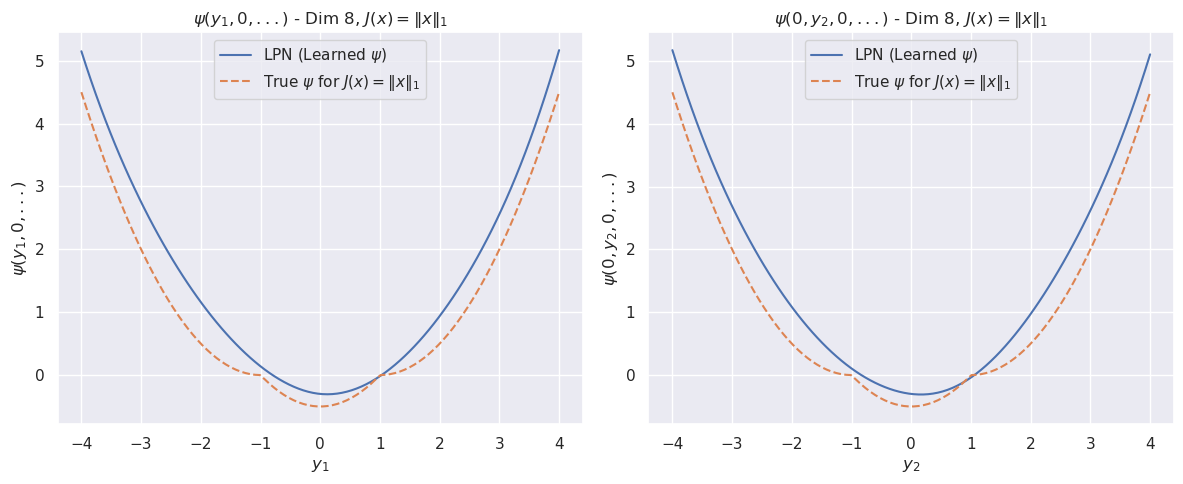

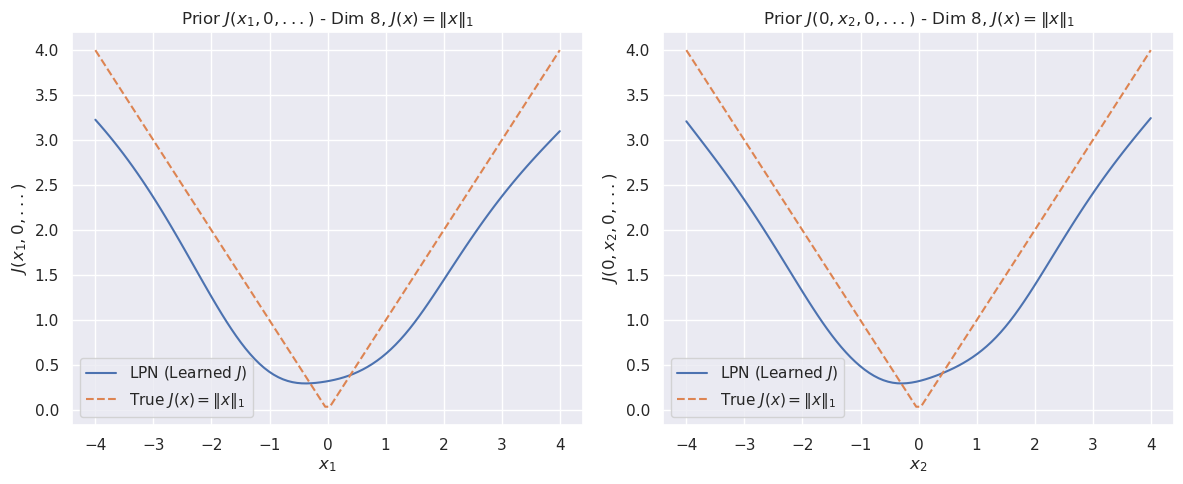

In [8]:
# L1 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

psi_x_k = lpn_model_quad_l1.scalar(x_k_tensor)

y_k_tensor = lpn_model_quad_l1(x_k_tensor)

inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

tensor([[-0.2988,  0.8292, -3.1744,  ..., -2.2532, -1.3970, -0.6038],
        [-0.3813,  0.0959, -0.2324,  ...,  2.0792, -2.7338,  0.6469],
        [-0.2436,  0.1959, -1.9090,  ...,  2.6601, -0.6832,  0.7044],
        ...,
        [ 0.2695, -0.0696,  0.0691,  ..., -0.9156, -2.1477, -0.1987],
        [-0.0833, -0.1977, -1.6537,  ...,  2.7516, -1.9115, -1.8435],
        [ 0.1789, -2.0221, -1.0343,  ...,  0.4740,  0.0954,  2.0169]],
       device='cuda:0')

In [10]:
# --- Step 3: Train 2nd LPN ---
print("\n--- Training Second LPN for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=1, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN for Concave Quadratic Prior ---
iteration 0 loss 15.86253833770752
iteration 0 loss 118.33853149414062


iteration 500 loss 9.96096134185791


iteration 1000 loss 8.880157470703125


iteration 1500 loss 7.121506690979004


iteration 2000 loss 4.596001148223877


iteration 2500 loss 1.925068736076355


iteration 3000 loss 0.6391538977622986


iteration 3500 loss 0.28414568305015564


iteration 4000 loss 0.16312970221042633


iteration 4500 loss 0.09743840247392654


iteration 5000 loss 0.05747535079717636


iteration 5500 loss 0.03471582755446434


iteration 6000 loss 0.023581698536872864


iteration 6500 loss 0.017937147989869118


iteration 7000 loss 0.015528351068496704


iteration 7500 loss 0.014230923727154732


iteration 8000 loss 0.013026680797338486


iteration 8500 loss 0.011875362135469913


iteration 9000 loss 0.010781100019812584


iteration 9500 loss 0.009754142723977566


iteration 10000 loss 0.00889588426798582


iteration 10500 loss 0.008478476665914059


iteration 11000 loss 0.008057649247348309


iteration 11500 loss 0.007605266757309437


iteration 12000 loss 0.007127888035029173


iteration 12500 loss 0.006636058446019888


iteration 13000 loss 0.006492828484624624


iteration 13500 loss 0.006333313882350922


iteration 14000 loss 0.006151393987238407


iteration 14500 loss 0.005942408461123705


iteration 15000 loss 0.005706131923943758


iteration 15500 loss 0.005445722956210375


iteration 16000 loss 0.005328179802745581


iteration 16500 loss 0.005228162743151188


iteration 17000 loss 0.0051122852601110935


iteration 17500 loss 0.004976167809218168


iteration 18000 loss 0.004817940294742584


iteration 18500 loss 0.004716554190963507


iteration 19000 loss 0.004652030300348997


iteration 19500 loss 0.004585979040712118


iteration 20000 loss 0.0045074354857206345


iteration 20500 loss 0.004413201939314604


iteration 21000 loss 0.004301029723137617


iteration 21500 loss 0.004266863688826561


iteration 22000 loss 0.004225205164402723


iteration 22500 loss 0.004179378971457481


iteration 23000 loss 0.004124196246266365


iteration 23500 loss 0.0040571498684585094


iteration 24000 loss 0.003976329229772091


iteration 24500 loss 0.0039342958480119705


iteration 25000 loss 0.003898201510310173


iteration 25500 loss 0.0038574927020817995


iteration 26000 loss 0.003807896049693227


iteration 26500 loss 0.0037472257390618324


iteration 27000 loss 0.003848216962069273


iteration 27500 loss 0.003665445139631629


iteration 28000 loss 0.0036375175695866346


iteration 28500 loss 0.0036052942741662264


iteration 29000 loss 0.003565861377865076


iteration 29500 loss 0.0035173483192920685


iteration 30000 loss 0.00347858271561563


iteration 30500 loss 0.003444783156737685


iteration 31000 loss 0.0034124634694308043


iteration 31500 loss 0.003373329760506749


iteration 32000 loss 0.003325454657897353


iteration 32500 loss 0.003305681049823761


iteration 33000 loss 0.0032815905287861824


iteration 33500 loss 0.0032567379530519247


iteration 34000 loss 0.0032269139774143696


iteration 34500 loss 0.0031902131158858538


iteration 35000 loss 0.003165865782648325


iteration 35500 loss 0.0031441834289580584


iteration 36000 loss 0.003124035196378827


iteration 36500 loss 0.003100035944953561


iteration 37000 loss 0.0030704776290804148


iteration 37500 loss 0.003034000750631094


iteration 38000 loss 0.003025972982868552


iteration 38500 loss 0.003009064355865121


iteration 39000 loss 0.002990932436659932


iteration 39500 loss 0.0029691059608012438


iteration 40000 loss 0.0029422470834106207


iteration 40500 loss 0.002927742199972272


iteration 41000 loss 0.0029072945471853018


iteration 41500 loss 0.002891311189159751


iteration 42000 loss 0.002873246092349291


iteration 42500 loss 0.0028512782882899046


iteration 43000 loss 0.0028301875572651625


iteration 43500 loss 0.002818338107317686


iteration 44000 loss 0.0028044774662703276


iteration 44500 loss 0.0027892584912478924


iteration 45000 loss 0.002770806197077036


iteration 45500 loss 0.009772052057087421


iteration 46000 loss 0.0027398611418902874


iteration 46500 loss 0.0027257981710135937


iteration 47000 loss 0.002709236228838563


iteration 47500 loss 0.0026898363139480352


iteration 48000 loss 0.0026773433201014996


iteration 48500 loss 0.002662980929017067


iteration 49000 loss 0.0026472739409655333


iteration 49500 loss 0.0026280824095010757


iteration 50000 loss 0.0026215510442852974


iteration 50500 loss 0.0026091313920915127


iteration 51000 loss 0.0025980183854699135


iteration 51500 loss 0.0025854476261883974


iteration 52000 loss 0.0025701660197228193


iteration 52500 loss 0.0025615945924073458


iteration 53000 loss 0.0025499172043055296


iteration 53500 loss 0.0025388107169419527


iteration 54000 loss 0.0025255864020437002


iteration 54500 loss 0.0025160457007586956


iteration 55000 loss 0.0025027431547641754


iteration 55500 loss 0.00249029160477221


iteration 56000 loss 0.0024753084871917963


iteration 56500 loss 0.0024682211223989725


iteration 57000 loss 0.002456765854731202


iteration 57500 loss 0.002443536650389433


iteration 58000 loss 0.002436421811580658


iteration 58500 loss 0.002424637321382761


iteration 59000 loss 0.0024139340966939926


iteration 59500 loss 0.0024013465736061335


iteration 60000 loss 0.0023973637726157904


iteration 60500 loss 0.0023876847699284554


iteration 61000 loss 0.0023793422151356936


iteration 61500 loss 0.0023700962774455547


iteration 62000 loss 0.0023589148186147213


iteration 62500 loss 0.0023541816044598818


iteration 63000 loss 0.002345514018088579


iteration 63500 loss 0.0023370154667645693


iteration 64000 loss 0.002326948568224907


iteration 64500 loss 0.0023218956775963306


iteration 65000 loss 0.00231125857681036


iteration 65500 loss 0.0023022175300866365


iteration 66000 loss 0.0022916817106306553


iteration 66500 loss 0.0022884742356836796


iteration 67000 loss 0.002279891399666667


iteration 67500 loss 0.002272159093990922


iteration 68000 loss 0.0022633993066847324


iteration 68500 loss 0.0022527070250362158


iteration 69000 loss 0.0022488082759082317


iteration 69500 loss 0.002240654779598117


iteration 70000 loss 0.0022319417912513018


iteration 70500 loss 0.0022213736083358526


iteration 71000 loss 0.002218236681073904


iteration 71500 loss 0.002210453385487199


iteration 72000 loss 0.0022024039644747972


iteration 72500 loss 0.002192768268287182


iteration 73000 loss 0.002192336367443204


iteration 73500 loss 0.002185630379244685


iteration 74000 loss 0.002179635688662529


iteration 74500 loss 0.002173165325075388


iteration 75000 loss 0.0021654837764799595


iteration 75500 loss 0.0021615272853523493


iteration 76000 loss 0.0021542247850447893


iteration 76500 loss 0.0021476843394339085


iteration 77000 loss 0.0021400032564997673


iteration 77500 loss 0.0021366379223763943


iteration 78000 loss 0.0021287582349032164


iteration 78500 loss 0.002121760742738843


iteration 79000 loss 0.0021237211767584085


iteration 79500 loss 0.0021107124630361795


iteration 80000 loss 0.0021045038010925055


iteration 80500 loss 0.0020972280763089657


iteration 81000 loss 0.002094292314723134


iteration 81500 loss 0.0020880347583442926


iteration 82000 loss 0.002081380458548665


iteration 82500 loss 0.002079610712826252


iteration 83000 loss 0.0020723030902445316


iteration 83500 loss 0.0020663875620812178


iteration 84000 loss 0.0020597989205271006


iteration 84500 loss 0.0020583048462867737


iteration 85000 loss 0.0020517955999821424


iteration 85500 loss 0.0020462682005017996


iteration 86000 loss 0.002040146617218852


iteration 86500 loss 0.0020377940963953733


iteration 87000 loss 0.0020310450345277786


iteration 87500 loss 0.002025151625275612


iteration 88000 loss 0.002023600973188877


iteration 88500 loss 0.0020161056891083717


iteration 89000 loss 0.0020105361472815275


iteration 89500 loss 0.0020040972158312798


iteration 90000 loss 0.002001743530854583


iteration 90500 loss 0.0019965912215411663


iteration 91000 loss 0.0019912237767130136


iteration 91500 loss 0.002018442377448082


iteration 92000 loss 0.001982344314455986


iteration 92500 loss 0.001976726343855262


iteration 93000 loss 0.001970312325283885


iteration 93500 loss 0.0019689544569700956


iteration 94000 loss 0.0019636896904557943


iteration 94500 loss 0.001958200940862298


iteration 95000 loss 0.0019561094231903553


iteration 95500 loss 0.001950012519955635


iteration 96000 loss 0.0019446233054623008


iteration 96500 loss 0.001942391274496913


iteration 97000 loss 0.0019364565378054976


iteration 97500 loss 0.0019312080694362521


iteration 98000 loss 0.001932863611727953


iteration 98500 loss 0.0019251179182901978


iteration 99000 loss 0.0019207090372219682


iteration 99500 loss 0.0019161173840984702


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.0019106921972706914


iteration 100500 loss 0.0019100133795291185


iteration 101000 loss 0.0019091488793492317


iteration 101500 loss 0.0019080296624451876


iteration 102000 loss 0.001906605320982635


iteration 102500 loss 0.001904787844978273


iteration 103000 loss 0.0019024689681828022


iteration 103500 loss 0.0018995138816535473


iteration 104000 loss 0.0018957577412948012


iteration 104500 loss 0.001890980638563633


iteration 105000 loss 0.0018849263433367014


iteration 105500 loss 0.001879593706689775


iteration 106000 loss 0.001877110917121172


iteration 106500 loss 0.0018740386003628373


iteration 107000 loss 0.0018701289081946015


iteration 107500 loss 0.001865156926214695


iteration 108000 loss 0.0018588551320135593


iteration 108500 loss 0.0018559872405603528


iteration 109000 loss 0.0018541589379310608


iteration 109500 loss 0.0018518590368330479


iteration 110000 loss 0.0018489230424165726


iteration 110500 loss 0.0018451792420819402


iteration 111000 loss 0.0018404241418465972


iteration 111500 loss 0.0018344108248129487


iteration 112000 loss 0.0018313723849132657


iteration 112500 loss 0.001829009735956788


iteration 113000 loss 0.0018260106444358826


iteration 113500 loss 0.0018221877980977297


iteration 114000 loss 0.0018173283897340298


iteration 114500 loss 0.0018111654790118337


iteration 115000 loss 0.0018086720956489444


iteration 115500 loss 0.0018062797607854009


iteration 116000 loss 0.0018032420193776488


iteration 116500 loss 0.0017993681831285357


iteration 117000 loss 0.001794440788216889


iteration 117500 loss 0.0017895568162202835


iteration 118000 loss 0.0017874272307381034


iteration 118500 loss 0.001784885418601334


iteration 119000 loss 0.001781646627932787


iteration 119500 loss 0.0017775245942175388


iteration 120000 loss 0.001772276940755546


iteration 120500 loss 0.0017688105581328273


iteration 121000 loss 0.0017670977395027876


iteration 121500 loss 0.0017649760702624917


iteration 122000 loss 0.0017622709274291992


iteration 122500 loss 0.001758819562382996


iteration 123000 loss 0.001754428376443684


iteration 123500 loss 0.0017767248209565878


iteration 124000 loss 0.0017479055095463991


iteration 124500 loss 0.0017463144613429904


iteration 125000 loss 0.0017442959360778332


iteration 125500 loss 0.0017417147755622864


iteration 126000 loss 0.0017384190578013659


iteration 126500 loss 0.0017342239152640104


iteration 127000 loss 0.0017298442544415593


iteration 127500 loss 0.0017278124578297138


iteration 128000 loss 0.0017254757694900036


iteration 128500 loss 0.001722500892356038


iteration 129000 loss 0.0017187106423079967


iteration 129500 loss 0.0017138890689238906


iteration 130000 loss 0.0017110834596678615


iteration 130500 loss 0.001709737116470933


iteration 131000 loss 0.0017080706311389804


iteration 131500 loss 0.0017059448873624206


iteration 132000 loss 0.0017032291507348418


iteration 132500 loss 0.0016997655620798469


iteration 133000 loss 0.0016953606391325593


iteration 133500 loss 0.001692284015007317


iteration 134000 loss 0.0016909933183342218


iteration 134500 loss 0.0016894149594008923


iteration 135000 loss 0.0016874055145308375


iteration 135500 loss 0.001684841699898243


iteration 136000 loss 0.0016815693816170096


iteration 136500 loss 0.0016774032264947891


iteration 137000 loss 0.001674058847129345


iteration 137500 loss 0.0016728187911212444


iteration 138000 loss 0.0016713719815015793


iteration 138500 loss 0.001669529010541737


iteration 139000 loss 0.0016671735793352127


iteration 139500 loss 0.0016641683178022504


iteration 140000 loss 0.0016603387193754315


iteration 140500 loss 0.0016569937579333782


iteration 141000 loss 0.0016557316994294524


iteration 141500 loss 0.0016543108504265547


iteration 142000 loss 0.0016525061801075935


iteration 142500 loss 0.0016501984791830182


iteration 143000 loss 0.0016472549177706242


iteration 143500 loss 0.0016435080906376243


iteration 144000 loss 0.0016398673178628087


iteration 144500 loss 0.0016386046772822738


iteration 145000 loss 0.0016373377293348312


iteration 145500 loss 0.0016357317799702287


iteration 146000 loss 0.0016336848493665457


iteration 146500 loss 0.0016310714418068528


iteration 147000 loss 0.001627742894925177


iteration 147500 loss 0.0016235188813880086


iteration 148000 loss 0.0016222742851823568


iteration 148500 loss 0.0016209488967433572


iteration 149000 loss 0.001619262038730085


iteration 149500 loss 0.0016171078896149993


iteration 150000 loss 0.0016143606044352055


iteration 150500 loss 0.0016108595300465822


iteration 151000 loss 0.0016074796440079808


iteration 151500 loss 0.0016061401693150401


iteration 152000 loss 0.0016045946395024657


iteration 152500 loss 0.001602625590749085


iteration 153000 loss 0.0016001132316887379


iteration 153500 loss 0.001596913207322359


iteration 154000 loss 0.0015929349465295672


iteration 154500 loss 0.0015915744006633759


iteration 155000 loss 0.0015899925492703915


iteration 155500 loss 0.0015879797283560038


iteration 156000 loss 0.0015854152152314782


iteration 156500 loss 0.0015821453416720033


iteration 157000 loss 0.0015790493926033378


iteration 157500 loss 0.0015777366934344172


iteration 158000 loss 0.0015762075781822205


iteration 158500 loss 0.0015742573887109756


iteration 159000 loss 0.0015717692440375686


iteration 159500 loss 0.0015685965772718191


iteration 160000 loss 0.0015653737355023623


iteration 160500 loss 0.001563848345540464


iteration 161000 loss 0.0015623209765180945


iteration 161500 loss 0.0015603749779984355


iteration 162000 loss 0.0015578892780467868


iteration 162500 loss 0.001554719521664083


iteration 163000 loss 0.0015519309090450406


iteration 163500 loss 0.0015508478973060846


iteration 164000 loss 0.001549694687128067


iteration 164500 loss 0.001548226922750473


iteration 165000 loss 0.0015463547315448523


iteration 165500 loss 0.0015439626295119524


iteration 166000 loss 0.0015409152256324887


iteration 166500 loss 0.0015383379068225622


iteration 167000 loss 0.0015370335895568132


iteration 167500 loss 0.0015354524366557598


iteration 168000 loss 0.0015334374038502574


iteration 168500 loss 0.0015308664878830314


iteration 169000 loss 0.0015275885816663504


iteration 169500 loss 0.001526107545942068


iteration 170000 loss 0.0015250265132635832


iteration 170500 loss 0.0015236615436151624


iteration 171000 loss 0.0015219195047393441


iteration 171500 loss 0.001519692363217473


iteration 172000 loss 0.001516848336905241


iteration 172500 loss 0.0015141199110075831


iteration 173000 loss 0.001513072056695819


iteration 173500 loss 0.0015120988246053457


iteration 174000 loss 0.001510867034085095


iteration 174500 loss 0.0015092921676114202


iteration 175000 loss 0.001507279579527676


iteration 175500 loss 0.001504709362052381


iteration 176000 loss 0.0015014458913356066


iteration 176500 loss 0.0015005571767687798


iteration 177000 loss 0.0014995647361502051


iteration 177500 loss 0.001498324447311461


iteration 178000 loss 0.0014967398019507527


iteration 178500 loss 0.0014947185991331935


iteration 179000 loss 0.0014921539695933461


iteration 179500 loss 0.0014932233607396483


iteration 180000 loss 0.0014883982948958874


iteration 180500 loss 0.001487452769652009


iteration 181000 loss 0.0014862524112686515


iteration 181500 loss 0.0014847175916656852


iteration 182000 loss 0.0014827558770775795


iteration 182500 loss 0.0014802548103034496


iteration 183000 loss 0.0014779351186007261


iteration 183500 loss 0.0014769063564017415


iteration 184000 loss 0.0014758408069610596


iteration 184500 loss 0.0014744861982762814


iteration 185000 loss 0.0014727601082995534


iteration 185500 loss 0.0014705548528581858


iteration 186000 loss 0.0014677495928481221


iteration 186500 loss 0.0014663597103208303


iteration 187000 loss 0.0014654862461611629


iteration 187500 loss 0.0014644291950389743


iteration 188000 loss 0.0014630801742896438


iteration 188500 loss 0.001461357926018536


iteration 189000 loss 0.0014591565122827888


iteration 189500 loss 0.001456357422284782


iteration 190000 loss 0.001455056481063366


iteration 190500 loss 0.0014542336575686932


iteration 191000 loss 0.0014532090863212943


iteration 191500 loss 0.0014518979005515575


iteration 192000 loss 0.0014502211706712842


iteration 192500 loss 0.0014480832032859325


iteration 193000 loss 0.001445355243049562


iteration 193500 loss 0.0014439636142924428


iteration 194000 loss 0.0014428859576582909


iteration 194500 loss 0.0014415321638807654


iteration 195000 loss 0.0014398032799363136


iteration 195500 loss 0.001437600003555417


iteration 196000 loss 0.0014360127970576286


iteration 196500 loss 0.0014341926435008645


iteration 197000 loss 0.0014334100997075438


iteration 197500 loss 0.0014324308140203357


iteration 198000 loss 0.0014311756240203977


iteration 198500 loss 0.001429573749192059


iteration 199000 loss 0.0014275258872658014


iteration 199500 loss 0.0014249201631173491


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.0014240293530747294


iteration 200500 loss 0.0014239471638575196


iteration 201000 loss 0.0014238430885598063


iteration 201500 loss 0.0014237004797905684


iteration 202000 loss 0.0014235192211344838


iteration 202500 loss 0.0014232770772650838


iteration 203000 loss 0.0014229664811864495


iteration 203500 loss 0.0014225677587091923


iteration 204000 loss 0.0014220686862245202


iteration 204500 loss 0.0014214294496923685


iteration 205000 loss 0.001420612446963787


iteration 205500 loss 0.0014195776311680675


iteration 206000 loss 0.00141826958861202


iteration 206500 loss 0.001416626269929111


iteration 207000 loss 0.0014145777095109224


iteration 207500 loss 0.0014123300788924098


iteration 208000 loss 0.0014110613847151399


iteration 208500 loss 0.0014097560197114944


iteration 209000 loss 0.0014081182889640331


iteration 209500 loss 0.001406076829880476


iteration 210000 loss 0.0014037737855687737


iteration 210500 loss 0.0014031043974682689


iteration 211000 loss 0.0014022575924172997


iteration 211500 loss 0.0014011869207024574


iteration 212000 loss 0.001399837201461196


iteration 212500 loss 0.0013981442898511887


iteration 213000 loss 0.0013960431097075343


iteration 213500 loss 0.0013942542718723416


iteration 214000 loss 0.0013935569440945983


iteration 214500 loss 0.00139267195481807


iteration 215000 loss 0.0013915529707446694


iteration 215500 loss 0.0013901450438424945


iteration 216000 loss 0.0013883830979466438


iteration 216500 loss 0.001386200194247067


iteration 217000 loss 0.0013847944792360067


iteration 217500 loss 0.0013838892336934805


iteration 218000 loss 0.001382743357680738


iteration 218500 loss 0.0013813026016578078


iteration 219000 loss 0.001379501074552536


iteration 219500 loss 0.001377271837554872


iteration 220000 loss 0.0013764066388830543


iteration 220500 loss 0.0013756650732830167


iteration 221000 loss 0.0013747266493737698


iteration 221500 loss 0.0013735424727201462


iteration 222000 loss 0.0013720517745241523


iteration 222500 loss 0.0013701978605240583


iteration 223000 loss 0.0013680814299732447


iteration 223500 loss 0.0013672144850715995


iteration 224000 loss 0.0013661191333085299


iteration 224500 loss 0.0013647421728819609


iteration 225000 loss 0.0013630192261189222


iteration 225500 loss 0.0013608902227133512


iteration 226000 loss 0.0013598853256553411


iteration 226500 loss 0.0013589942827820778


iteration 227000 loss 0.0013578656362369657


iteration 227500 loss 0.001356450724415481


iteration 228000 loss 0.0013546826085075736


iteration 228500 loss 0.0013526143738999963


iteration 229000 loss 0.0013520312495529652


iteration 229500 loss 0.0013513299636542797


iteration 230000 loss 0.0013504420639947057


iteration 230500 loss 0.0013493188889697194


iteration 231000 loss 0.0013479093322530389


iteration 231500 loss 0.0013461514608934522


iteration 232000 loss 0.0013441541232168674


iteration 232500 loss 0.0013435963774099946


iteration 233000 loss 0.0013429161626845598


iteration 233500 loss 0.001342052360996604


iteration 234000 loss 0.0013409605016931891


iteration 234500 loss 0.0013395884307101369


iteration 235000 loss 0.0013378761941567063


iteration 235500 loss 0.0013359275180846453


iteration 236000 loss 0.0013353764079511166


iteration 236500 loss 0.0013346814084798098


iteration 237000 loss 0.0013338017743080854


iteration 237500 loss 0.0013326907064765692


iteration 238000 loss 0.001331294304691255


iteration 238500 loss 0.0013295557582750916


iteration 239000 loss 0.0013278344413265586


iteration 239500 loss 0.0013271239586174488


iteration 240000 loss 0.0013262225547805429


iteration 240500 loss 0.0013250875053927302


iteration 241000 loss 0.0013236621161922812


iteration 241500 loss 0.001321888412348926


iteration 242000 loss 0.0013203734997659922


iteration 242500 loss 0.0013196819927543402


iteration 243000 loss 0.0013188051525503397


iteration 243500 loss 0.001317700371146202


iteration 244000 loss 0.001316313399001956


iteration 244500 loss 0.0013145850971341133


iteration 245000 loss 0.0013130264123901725


iteration 245500 loss 0.0013122590025886893


iteration 246000 loss 0.0013112890301272273


iteration 246500 loss 0.0013100673677399755


iteration 247000 loss 0.0013085408136248589


iteration 247500 loss 0.0013066456886008382


iteration 248000 loss 0.001305890385992825


iteration 248500 loss 0.0013051626738160849


iteration 249000 loss 0.0013042420614510775


iteration 249500 loss 0.001303081400692463


iteration 250000 loss 0.0013016288867220283


iteration 250500 loss 0.00129982631187886


iteration 251000 loss 0.0012989469105377793


iteration 251500 loss 0.0012983337510377169


iteration 252000 loss 0.0012975586578249931


iteration 252500 loss 0.0012965797213837504


iteration 253000 loss 0.0012953478144481778


iteration 253500 loss 0.001293809269554913


iteration 254000 loss 0.0012920264853164554


iteration 254500 loss 0.001291262567974627


iteration 255000 loss 0.0012902989983558655


iteration 255500 loss 0.0012890859507024288


iteration 256000 loss 0.0012875699903815985


iteration 256500 loss 0.001285839593037963


iteration 257000 loss 0.0012853866210207343


iteration 257500 loss 0.0012848160695284605


iteration 258000 loss 0.0012840868439525366


iteration 258500 loss 0.001283169025555253


iteration 259000 loss 0.001282011391595006


iteration 259500 loss 0.00128056516405195


iteration 260000 loss 0.001278775162063539


iteration 260500 loss 0.0012781932018697262


iteration 261000 loss 0.0012776079820469022


iteration 261500 loss 0.0012768645538017154


iteration 262000 loss 0.0012759245000779629


iteration 262500 loss 0.0012747399741783738


iteration 263000 loss 0.0012732625473290682


iteration 263500 loss 0.0012716860510408878


iteration 264000 loss 0.0012712450698018074


iteration 264500 loss 0.001270682318136096


iteration 265000 loss 0.0012699654325842857


iteration 265500 loss 0.0012690607691183686


iteration 266000 loss 0.001267921761609614


iteration 266500 loss 0.0012664981186389923


iteration 267000 loss 0.001264852937310934


iteration 267500 loss 0.0012643610825762153


iteration 268000 loss 0.0012637418694794178


iteration 268500 loss 0.0012629576958715916


iteration 269000 loss 0.0012619689805433154


iteration 269500 loss 0.001260728924535215


iteration 270000 loss 0.001259181066416204


iteration 270500 loss 0.0012581080663949251


iteration 271000 loss 0.0012575859436765313


iteration 271500 loss 0.0012569236569106579


iteration 272000 loss 0.0012560866307467222


iteration 272500 loss 0.001255032024346292


iteration 273000 loss 0.001253708265721798


iteration 273500 loss 0.0012520670425146818


iteration 274000 loss 0.0012512428220361471


iteration 274500 loss 0.0012503813486546278


iteration 275000 loss 0.0012492949608713388


iteration 275500 loss 0.0012479358119890094


iteration 276000 loss 0.0012463396415114403


iteration 276500 loss 0.0012458604760468006


iteration 277000 loss 0.0012452598894014955


iteration 277500 loss 0.0012445002794265747


iteration 278000 loss 0.0012435406679287553


iteration 278500 loss 0.0012423372827470303


iteration 279000 loss 0.0012408365728333592


iteration 279500 loss 0.001239864039234817


iteration 280000 loss 0.0012392427306622267


iteration 280500 loss 0.001238458789885044


iteration 281000 loss 0.0012374697253108025


iteration 281500 loss 0.0012362280394881964


iteration 282000 loss 0.0012346834409981966


iteration 282500 loss 0.0012339450186118484


iteration 283000 loss 0.001233504037372768


iteration 283500 loss 0.0012329397723078728


iteration 284000 loss 0.0012322261463850737


iteration 284500 loss 0.0012313240440562367


iteration 285000 loss 0.0012301913229748607


iteration 285500 loss 0.0012287780409678817


iteration 286000 loss 0.0012277616187930107


iteration 286500 loss 0.0012273434549570084


iteration 287000 loss 0.0012268077116459608


iteration 287500 loss 0.0012261285446584225


iteration 288000 loss 0.001225271262228489


iteration 288500 loss 0.001224192208610475


iteration 289000 loss 0.0012228434206917882


iteration 289500 loss 0.0012216492323204875


iteration 290000 loss 0.0012212235014885664


iteration 290500 loss 0.0012206773972138762


iteration 291000 loss 0.0012199875200167298


iteration 291500 loss 0.0012191159185022116


iteration 292000 loss 0.001218019868247211


iteration 292500 loss 0.0012166535016149282


iteration 293000 loss 0.001215634634718299


iteration 293500 loss 0.0012152333511039615


iteration 294000 loss 0.001214721705764532


iteration 294500 loss 0.0012140714097768068


iteration 295000 loss 0.0012132490519434214


iteration 295500 loss 0.0012122144689783454


iteration 296000 loss 0.0012109227245673537


iteration 296500 loss 0.0012097293511033058


iteration 297000 loss 0.0012093228287994862


iteration 297500 loss 0.0012088031508028507


iteration 298000 loss 0.0012081449385732412


iteration 298500 loss 0.0012073128018528223


iteration 299000 loss 0.0012062654132023454


iteration 299500 loss 0.0012049578363075852


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.0012038764543831348


iteration 300500 loss 0.001203843392431736


iteration 301000 loss 0.0012037995038554072


iteration 301500 loss 0.001203741761855781


iteration 302000 loss 0.0012036616681143641


iteration 302500 loss 0.001203560852445662


iteration 303000 loss 0.0012034315150231123


iteration 303500 loss 0.0012032598024234176


iteration 304000 loss 0.0012030447833240032


iteration 304500 loss 0.0012027875054627657


iteration 305000 loss 0.0012024844763800502


iteration 305500 loss 0.0012021292932331562


iteration 306000 loss 0.0012017171829938889


iteration 306500 loss 0.001201246865093708


iteration 307000 loss 0.001200716127641499


iteration 307500 loss 0.001200124155730009


iteration 308000 loss 0.0011994850356131792


iteration 308500 loss 0.0011988088954240084


iteration 309000 loss 0.0011981155257672071


iteration 309500 loss 0.0011974278604611754


iteration 310000 loss 0.0011967438040301204


iteration 310500 loss 0.0011960634728893638


iteration 311000 loss 0.0011953851208090782


iteration 311500 loss 0.0011947116581723094


iteration 312000 loss 0.001194039941765368


iteration 312500 loss 0.001193373929709196


iteration 313000 loss 0.0011927129235118628


iteration 313500 loss 0.0011920512188225985


iteration 314000 loss 0.00119139370508492


iteration 314500 loss 0.0011907379375770688


iteration 315000 loss 0.001190084614790976


iteration 315500 loss 0.001189434784464538


iteration 316000 loss 0.0011887873988598585


iteration 316500 loss 0.0011881418759003282


iteration 317000 loss 0.001187496935017407


iteration 317500 loss 0.0011868539731949568


iteration 318000 loss 0.0011862126411870122


iteration 318500 loss 0.0011855749180540442


iteration 319000 loss 0.0011849366128444672


iteration 319500 loss 0.0011843012180179358


iteration 320000 loss 0.0011836700141429901


iteration 320500 loss 0.0011830388102680445


iteration 321000 loss 0.0011824091197922826


iteration 321500 loss 0.0011817807098850608


iteration 322000 loss 0.0011811546282842755


iteration 322500 loss 0.0011805292451754212


iteration 323000 loss 0.0011799072381109


iteration 323500 loss 0.0011792861623689532


iteration 324000 loss 0.001178666134364903


iteration 324500 loss 0.001178047969006002


iteration 325000 loss 0.0011774335289373994


iteration 325500 loss 0.0011768174590542912


iteration 326000 loss 0.0011762045323848724


iteration 326500 loss 0.0011755925370380282


iteration 327000 loss 0.0011749817058444023


iteration 327500 loss 0.0011743728537112474


iteration 328000 loss 0.0011737662134692073


iteration 328500 loss 0.0011731598060578108


iteration 329000 loss 0.0011725533986464143


iteration 329500 loss 0.0011719499016180634


iteration 330000 loss 0.0011713490821421146


iteration 330500 loss 0.001170748146250844


iteration 331000 loss 0.0011701480252668262


iteration 331500 loss 0.0011695498833432794


iteration 332000 loss 0.0011689519742503762


iteration 332500 loss 0.001168354065157473


iteration 333000 loss 0.0011677610455080867


iteration 333500 loss 0.0011671673273667693


iteration 334000 loss 0.0011665751226246357


iteration 334500 loss 0.0011659825686365366


iteration 335000 loss 0.0011653936235234141


iteration 335500 loss 0.0011648049112409353


iteration 336000 loss 0.0011642163153737783


iteration 336500 loss 0.0011636301642283797


iteration 337000 loss 0.001163044711574912


iteration 337500 loss 0.001162461587227881


iteration 338000 loss 0.0011618802091106772


iteration 338500 loss 0.0011612985981628299


iteration 339000 loss 0.0011607195483520627


iteration 339500 loss 0.0011601416626945138


iteration 340000 loss 0.0011595642426982522


iteration 340500 loss 0.0011589886853471398


iteration 341000 loss 0.0011584137100726366


iteration 341500 loss 0.0011578402481973171


iteration 342000 loss 0.0011572677176445723


iteration 342500 loss 0.001156697398982942


iteration 343000 loss 0.001156126381829381


iteration 343500 loss 0.0011555571109056473


iteration 344000 loss 0.0011549891205504537


iteration 344500 loss 0.001154422527179122


iteration 345000 loss 0.0011538559338077903


iteration 345500 loss 0.001153291086666286


iteration 346000 loss 0.0011527265887707472


iteration 346500 loss 0.0011521652340888977


iteration 347000 loss 0.00115160271525383


iteration 347500 loss 0.0011510407784953713


iteration 348000 loss 0.0011504829162731767


iteration 348500 loss 0.001149925752542913


iteration 349000 loss 0.0011493692873045802


iteration 349500 loss 0.0011488139862194657


iteration 350000 loss 0.0011482599657028913


iteration 350500 loss 0.001147707924246788


iteration 351000 loss 0.0011471559992060065


iteration 351500 loss 0.0011466052383184433


iteration 352000 loss 0.0011460584355518222


iteration 352500 loss 0.001145508955232799


iteration 353000 loss 0.0011449618032202125


iteration 353500 loss 0.0011444173287600279


iteration 354000 loss 0.0011438720393925905


iteration 354500 loss 0.001143330940976739


iteration 355000 loss 0.00114278809633106


iteration 355500 loss 0.0011422469979152083


iteration 356000 loss 0.001141707063652575


iteration 356500 loss 0.001141167595051229


iteration 357000 loss 0.0011406331323087215


iteration 357500 loss 0.0011400969233363867


iteration 358000 loss 0.001139559200964868


iteration 358500 loss 0.0011390302097424865


iteration 359000 loss 0.0011384945828467607


iteration 359500 loss 0.0011379581410437822


iteration 360000 loss 0.0011374247260391712


iteration 360500 loss 0.0011368929408490658


iteration 361000 loss 0.0011363591765984893


iteration 361500 loss 0.0011358294868841767


iteration 362000 loss 0.0011352980509400368


iteration 362500 loss 0.0011347689433023334


iteration 363000 loss 0.0011342422803863883


iteration 363500 loss 0.001133712474256754


iteration 364000 loss 0.0011331860441714525


iteration 364500 loss 0.0011326653184369206


iteration 365000 loss 0.0011321374913677573


iteration 365500 loss 0.0011316122254356742


iteration 366000 loss 0.0011310867266729474


iteration 366500 loss 0.0011305618099868298


iteration 367000 loss 0.001130037708207965


iteration 367500 loss 0.0011295136064291


iteration 368000 loss 0.0011289906688034534


iteration 368500 loss 0.001128469710238278


iteration 369000 loss 0.0011279485188424587


iteration 369500 loss 0.0011274287244305015


iteration 370000 loss 0.0011269105598330498


iteration 370500 loss 0.0011263928608968854


iteration 371000 loss 0.001125875860452652


iteration 371500 loss 0.0011253593256697059


iteration 372000 loss 0.0011248448863625526


iteration 372500 loss 0.0011243296321481466


iteration 373000 loss 0.0011238165898248553


iteration 373500 loss 0.0011233040131628513


iteration 374000 loss 0.0011227910872548819


iteration 374500 loss 0.0011222801404073834


iteration 375000 loss 0.0011217695428058505


iteration 375500 loss 0.0011212611570954323


iteration 376000 loss 0.0011207528878003359


iteration 376500 loss 0.0011202453169971704


iteration 377000 loss 0.0011197383282706141


iteration 377500 loss 0.0011192314559593797


iteration 378000 loss 0.0011187270283699036


iteration 378500 loss 0.0011182223679497838


iteration 379000 loss 0.0011177180567756295


iteration 379500 loss 0.0011172157246619463


iteration 380000 loss 0.0011167139746248722


iteration 380500 loss 0.0011162126902490854


iteration 381000 loss 0.0011157128028571606


iteration 381500 loss 0.0011152141960337758


iteration 382000 loss 0.0011147157056257129


iteration 382500 loss 0.0011142181465402246


iteration 383000 loss 0.0011137205874547362


iteration 383500 loss 0.001113225589506328


iteration 384000 loss 0.001112729893065989


iteration 384500 loss 0.0011122350115329027


iteration 385000 loss 0.0011117433896288276


iteration 385500 loss 0.0011112503707408905


iteration 386000 loss 0.0011107579339295626


iteration 386500 loss 0.0011102671269327402


iteration 387000 loss 0.0011097780661657453


iteration 387500 loss 0.0011092884233221412


iteration 388000 loss 0.0011088000610470772


iteration 388500 loss 0.001108312513679266


iteration 389000 loss 0.0011078257812187076


iteration 389500 loss 0.0011073383502662182


iteration 390000 loss 0.0011068517342209816


iteration 390500 loss 0.001106367213651538


iteration 391000 loss 0.001105883507989347


iteration 391500 loss 0.001105398521758616


iteration 392000 loss 0.0011049145832657814


iteration 392500 loss 0.0011044320417568088


iteration 393000 loss 0.0011039492674171925


iteration 393500 loss 0.0011034668423235416


iteration 394000 loss 0.0011029854649677873


iteration 394500 loss 0.0011025065323337913


iteration 395000 loss 0.0011020267847925425


iteration 395500 loss 0.0011015490163117647


iteration 396000 loss 0.0011010702000930905


iteration 396500 loss 0.001100593013688922


iteration 397000 loss 0.0011001172242686152


iteration 397500 loss 0.0010996423661708832


iteration 398000 loss 0.0010991678573191166


iteration 398500 loss 0.0010986935812979937


iteration 399000 loss 0.0010982214007526636


iteration 399500 loss 0.0010977478232234716


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.0010972770396620035


iteration 400500 loss 0.0010972409509122372


iteration 401000 loss 0.0010972021846100688


iteration 401500 loss 0.001097162370570004


iteration 402000 loss 0.001097121392376721


iteration 402500 loss 0.0010970800649374723


iteration 403000 loss 0.0010970362927764654


iteration 403500 loss 0.0010969927534461021


iteration 404000 loss 0.0010969499126076698


iteration 404500 loss 0.0010969053255394101


iteration 405000 loss 0.0010968615533784032


iteration 405500 loss 0.0010968177812173963


iteration 406000 loss 0.0010967730777338147


iteration 406500 loss 0.001096728490665555


iteration 407000 loss 0.0010966842528432608


iteration 407500 loss 0.0010966400150209665


iteration 408000 loss 0.0010965955443680286


iteration 408500 loss 0.0010965510737150908


iteration 409000 loss 0.0010965081164613366


iteration 409500 loss 0.001096464111469686


iteration 410000 loss 0.0010964189423248172


iteration 410500 loss 0.001096375402994454


iteration 411000 loss 0.0010963315144181252


iteration 411500 loss 0.0010962873930111527


iteration 412000 loss 0.0010962433880195022


iteration 412500 loss 0.0010962000815197825


iteration 413000 loss 0.0010961570078507066


iteration 413500 loss 0.001096112304367125


iteration 414000 loss 0.0010960694635286927


iteration 414500 loss 0.001096024876460433


iteration 415000 loss 0.0010959808714687824


iteration 415500 loss 0.0010959384962916374


iteration 416000 loss 0.0010958935599774122


iteration 416500 loss 0.001095851301215589


iteration 417000 loss 0.0010958064813166857


iteration 417500 loss 0.001095763873308897


iteration 418000 loss 0.0010957204503938556


iteration 418500 loss 0.0010956769110634923


iteration 419000 loss 0.001095633371733129


iteration 419500 loss 0.0010955900652334094


iteration 420000 loss 0.0010955467587336898


iteration 420500 loss 0.0010955044999718666


iteration 421000 loss 0.001095460494980216


iteration 421500 loss 0.0010954176541417837


iteration 422000 loss 0.0010953745804727077


iteration 422500 loss 0.0010953308083117008


iteration 423000 loss 0.0010952875018119812


iteration 423500 loss 0.0010952453594654799


iteration 424000 loss 0.0010952017037197948


iteration 424500 loss 0.0010951588628813624


iteration 425000 loss 0.0010951166041195393


iteration 425500 loss 0.001095074345357716


iteration 426000 loss 0.0010950299911201


iteration 426500 loss 0.0010949872666969895


iteration 427000 loss 0.0010949460556730628


iteration 427500 loss 0.0010949017014354467


iteration 428000 loss 0.0010948595590889454


iteration 428500 loss 0.0010948163690045476


iteration 429000 loss 0.0010947736445814371


iteration 429500 loss 0.0010947310365736485


iteration 430000 loss 0.0010946884285658598


iteration 430500 loss 0.001094646519050002


iteration 431000 loss 0.0010946034453809261


iteration 431500 loss 0.0010945606045424938


iteration 432000 loss 0.0010945171816274524


iteration 432500 loss 0.0010944756213575602


iteration 433000 loss 0.0010944325476884842


iteration 433500 loss 0.0010943898232653737


iteration 434000 loss 0.0010943474480882287


iteration 434500 loss 0.0010943051893264055


iteration 435000 loss 0.0010942625813186169


iteration 435500 loss 0.0010942199733108282


iteration 436000 loss 0.001094177714549005


iteration 436500 loss 0.001094136037863791


iteration 437000 loss 0.0010940941283479333


iteration 437500 loss 0.00109405058901757


iteration 438000 loss 0.0010940091451629996


iteration 438500 loss 0.0010939664207398891


iteration 439000 loss 0.0010939252097159624


iteration 439500 loss 0.0010938821360468864


iteration 440000 loss 0.0010938392952084541


iteration 440500 loss 0.0010937985498458147


iteration 441000 loss 0.001093755941838026


iteration 441500 loss 0.0010937136830762029


iteration 442000 loss 0.0010936717735603452


iteration 442500 loss 0.0010936293983832002


iteration 443000 loss 0.0010935872560366988


iteration 443500 loss 0.0010935448808595538


iteration 444000 loss 0.0010935029713436961


iteration 444500 loss 0.0010934608289971948


iteration 445000 loss 0.001093419617973268


iteration 445500 loss 0.0010933774756267667


iteration 446000 loss 0.0010933352168649435


iteration 446500 loss 0.001093293190933764


iteration 447000 loss 0.001093250815756619


iteration 447500 loss 0.0010932087898254395


iteration 448000 loss 0.0010931672295555472


iteration 448500 loss 0.0010931266006082296


iteration 449000 loss 0.0010930831776931882


iteration 449500 loss 0.0010930419666692615


iteration 450000 loss 0.0010929990094155073


iteration 450500 loss 0.0010929583804681897


iteration 451000 loss 0.001092915190383792


iteration 451500 loss 0.0010928746778517962


iteration 452000 loss 0.001092832419089973


iteration 452500 loss 0.0010927899274975061


iteration 453000 loss 0.0010927488328889012


iteration 453500 loss 0.0010927066905423999


iteration 454000 loss 0.0010926658287644386


iteration 454500 loss 0.001092623919248581


iteration 455000 loss 0.0010925824753940105


iteration 455500 loss 0.0010925410315394402


iteration 456000 loss 0.0010924993548542261


iteration 456500 loss 0.0010924572125077248


iteration 457000 loss 0.0010924155358225107


iteration 457500 loss 0.0010923739755526185


iteration 458000 loss 0.0010923314839601517


iteration 458500 loss 0.001092290971428156


iteration 459000 loss 0.0010922492947429419


iteration 459500 loss 0.0010922071523964405


iteration 460000 loss 0.0010921659413725138


iteration 460500 loss 0.0010921235661953688


iteration 461000 loss 0.0010920822387561202


iteration 461500 loss 0.001092041376978159


iteration 462000 loss 0.0010919994674623013


iteration 462500 loss 0.0010919581400230527


iteration 463000 loss 0.001091917511075735


iteration 463500 loss 0.0010918760672211647


iteration 464000 loss 0.0010918346233665943


iteration 464500 loss 0.0010917918989434838


iteration 465000 loss 0.001091750804334879


iteration 465500 loss 0.0010917092440649867


iteration 466000 loss 0.001091668731532991


iteration 466500 loss 0.0010916277533397079


iteration 467000 loss 0.0010915867751464248


iteration 467500 loss 0.001091544865630567


iteration 468000 loss 0.001091503887437284


iteration 468500 loss 0.0010914619779214263


iteration 469000 loss 0.0010914200684055686


iteration 469500 loss 0.0010913806036114693


iteration 470000 loss 0.0010913378791883588


iteration 470500 loss 0.0010912984143942595


iteration 471000 loss 0.0010912566212937236


iteration 471500 loss 0.0010912151774391532


iteration 472000 loss 0.001091174315661192


iteration 472500 loss 0.001091132638975978


iteration 473000 loss 0.0010910918936133385


iteration 473500 loss 0.0010910514974966645


iteration 474000 loss 0.0010910091223195195


iteration 474500 loss 0.001090968493372202


iteration 475000 loss 0.0010909276315942407


iteration 475500 loss 0.0010908852564170957


iteration 476000 loss 0.0010908452095463872


iteration 476500 loss 0.001090804347768426


iteration 477000 loss 0.0010907623218372464


iteration 477500 loss 0.0010907220421358943


iteration 478000 loss 0.0010906809475272894


iteration 478500 loss 0.0010906404349952936


iteration 479000 loss 0.001090599107556045


iteration 479500 loss 0.0010905583621934056


iteration 480000 loss 0.001090517151169479


iteration 480500 loss 0.001090476755052805


iteration 481000 loss 0.0010904360096901655


iteration 481500 loss 0.001090395380742848


iteration 482000 loss 0.0010903540533035994


iteration 482500 loss 0.0010903127258643508


iteration 483000 loss 0.0010902725625783205


iteration 483500 loss 0.0010902307694777846


iteration 484000 loss 0.0010901903733611107


iteration 484500 loss 0.0010901500936597586


iteration 485000 loss 0.0010901085333898664


iteration 485500 loss 0.0010900695342570543


iteration 486000 loss 0.001090028090402484


iteration 486500 loss 0.0010899873450398445


iteration 487000 loss 0.0010899462504312396


iteration 487500 loss 0.0010899052722379565


iteration 488000 loss 0.001089864643290639


iteration 488500 loss 0.0010898247128352523


iteration 489000 loss 0.0010897837346419692


iteration 489500 loss 0.0010897426400333643


iteration 490000 loss 0.0010897025931626558


iteration 490500 loss 0.0010896619642153382


iteration 491000 loss 0.0010896212188526988


iteration 491500 loss 0.0010895808227360249


iteration 492000 loss 0.0010895406594499946


iteration 492500 loss 0.0010894996812567115


iteration 493000 loss 0.0010894587030634284


iteration 493500 loss 0.0010894187726080418


iteration 494000 loss 0.0010893783764913678


iteration 494500 loss 0.001089336583390832


iteration 495000 loss 0.0010892967693507671


iteration 495500 loss 0.0010892577702179551


iteration 496000 loss 0.0010892163263633847


iteration 496500 loss 0.0010891754645854235


iteration 497000 loss 0.0010891356505453587


iteration 497500 loss 0.0010890953708440065


iteration 498000 loss 0.0010890548583120108


iteration 498500 loss 0.0010890142293646932


iteration 499000 loss 0.0010889742989093065


iteration 499500 loss 0.0010889337863773108


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


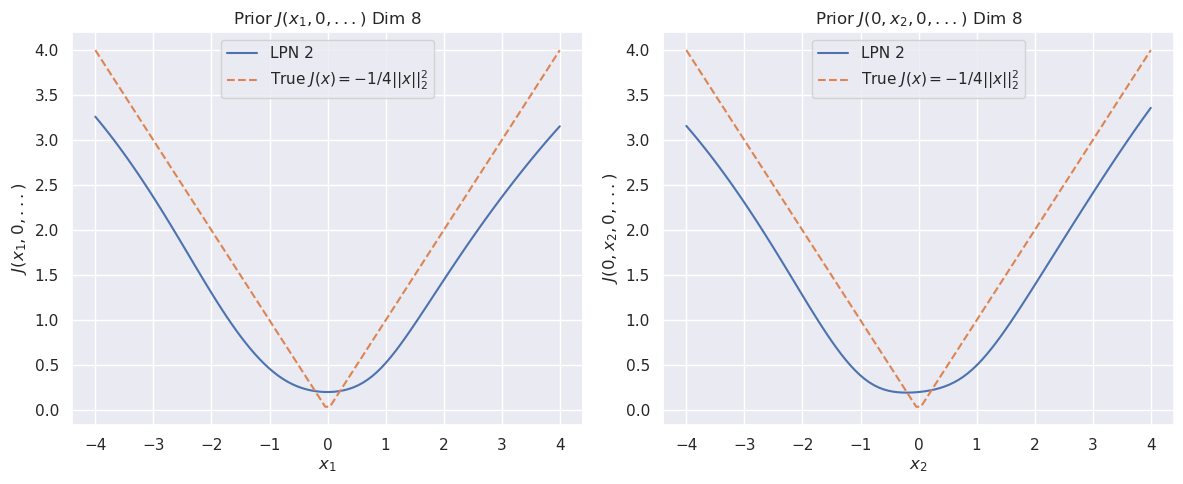

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)